In [ ]:
!pip install hdf5storage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 806.8 kB/s eta 0:00:00


In [ ]:
!pip install -U scikit-fuzzy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894078 sha256=135bc321a7cae1546feeb3c2e08686a8b5675de703e043bee62dcd2b4e922280
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import scipy
import scipy.misc
from scipy.io import loadmat, savemat
import datetime
import h5py
import hdf5storage
import skfuzzy as fuzz
from glob import glob
import  random
import time


In [10]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Project_DL_WC/cGAN_python/generated_img1")

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.enable_eager_execution(config=config)
layers = tf.keras.layers

In [12]:
def load_image_train(path, batch_size = 1):
    """load, jitter, and normalize"""
    with h5py.File(path, 'r') as file:
        real_image = np.transpose(np.array(file['output_da']))


    with h5py.File(path, 'r') as file:
        input_image = np.transpose(np.array(file['input_da']))

    # real_image = real_image[1:10,:,:,:]
    # input_image = input_image[1:10,:,:,:]

    SIZE_IN= real_image.shape
    list_im=list(range(0, SIZE_IN[0]))

    batch_im = random.sample(list_im,SIZE_IN[0])
    real_image = real_image[batch_im,:,:,:]
    input_image = input_image[batch_im,:,:,:]

    n_batches = int(SIZE_IN[0] / batch_size)

    for i in range(n_batches-1):
        imgs_A = real_image[i*batch_size:(i+1)*batch_size]
        imgs_B = input_image[i*batch_size:(i+1)*batch_size]


        yield imgs_A, imgs_B




def load_image_test(path, batch_size = 1):

    with h5py.File(path, 'r') as file:
        real_image = np.transpose(np.array(file['output_da_test']))


    with h5py.File(path, 'r') as file:
        input_image = np.transpose(np.array(file['input_da_test']))

    SIZE_IN= real_image.shape


    n_batches = int(SIZE_IN[0] / batch_size)

    for i in range(n_batches-1):
        imgs_A = real_image[i*batch_size:(i+1)*batch_size]
        imgs_B = input_image[i*batch_size:(i+1)*batch_size]


        yield imgs_A, imgs_B

def load_image_test_y(path):

    with h5py.File(path, 'r') as file:
        real_image = np.transpose(np.array(file['output_da_test']))


    with h5py.File(path, 'r') as file:
        input_image = np.transpose(np.array(file['input_da_test']))



    return real_image, input_image

In [13]:
"""
The architecture of generator is a modified U-Net.
There are skip connections between the encoder and decoder (as in U-Net).
"""


class EncoderLayer(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides_s = 2, apply_batchnorm=True, add = False, padding_s = 'same'):
        super(EncoderLayer, self).__init__()
        initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
        conv = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides_s,
                             padding=padding_s, kernel_initializer=initializer, use_bias=False)
        ac = layers.LeakyReLU()
        self.encoder_layer = None
        if add:
            self.encoder_layer = tf.keras.Sequential([conv])
        elif apply_batchnorm:
            bn = layers.BatchNormalization()
            self.encoder_layer = tf.keras.Sequential([conv, bn, ac])
        else:
            self.encoder_layer = tf.keras.Sequential([conv, ac])

    def call(self, x):
        return self.encoder_layer(x)


class DecoderLayer(tf.keras.Model):
    def __init__(self, filters, kernel_size, strides_s = 2, apply_dropout=False, add = False):
        super(DecoderLayer, self).__init__()
        initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
        dconv = layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides_s,
                                       padding='same', kernel_initializer=initializer, use_bias=False)
        bn = layers.BatchNormalization()
        ac = layers.ReLU()
        self.decoder_layer = None

        if add:
            self.decoder_layer = tf.keras.Sequential([dconv])
        elif apply_dropout:
            drop = layers.Dropout(rate=0.5)
            self.decoder_layer = tf.keras.Sequential([dconv, bn, drop, ac])
        else:
            self.decoder_layer = tf.keras.Sequential([dconv, bn, ac])




    def call(self, x):
        return self.decoder_layer(x)




class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        # Resize Input
        p_layer_1 = DecoderLayer(filters=2, kernel_size=4, strides_s = 2, apply_dropout=False, add = True)
        p_layer_2  = DecoderLayer(filters=2, kernel_size=4, strides_s = 2, apply_dropout=False, add = True)
        p_layer_3  = EncoderLayer(filters=2, kernel_size=(6,1),strides_s = (4,1), apply_batchnorm=False, add = True)

        self.p_layers = [p_layer_1,p_layer_2,p_layer_3]



        #encoder
        encoder_layer_1 = EncoderLayer(filters=64*1,  kernel_size=4,apply_batchnorm=False)
        encoder_layer_2 = EncoderLayer(filters=64*2, kernel_size=4)
        encoder_layer_3 = EncoderLayer(filters=64*4, kernel_size=4)
        encoder_layer_4 = EncoderLayer(filters=64*8, kernel_size=4)
        encoder_layer_5 = EncoderLayer(filters=64*8, kernel_size=4)
        self.encoder_layers = [encoder_layer_1, encoder_layer_2, encoder_layer_3, encoder_layer_4,
                               encoder_layer_5]

        # decoder
        decoder_layer_1 = DecoderLayer(filters=64*8, kernel_size=4, apply_dropout=True)
        decoder_layer_2 = DecoderLayer(filters=64*8, kernel_size=4,apply_dropout=True)
        decoder_layer_3 = DecoderLayer(filters=64*8, kernel_size=4, apply_dropout=True)
        decoder_layer_4 = DecoderLayer(filters=64*4, kernel_size=4)
        self.decoder_layers = [decoder_layer_1, decoder_layer_2, decoder_layer_3, decoder_layer_4]


        initializer = tf.random_normal_initializer(mean=0., stddev=0.02)
        self.last = layers.Conv2DTranspose(filters=2, kernel_size=4, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='tanh')

    def call(self, x):
        # pass the encoder and record xs
        for p_layer in self.p_layers:
            x = p_layer(x)

        encoder_xs = []
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
            encoder_xs.append(x)
        encoder_xs = encoder_xs[:-1][::-1]    # reverse
        assert len(encoder_xs) == 4

        # pass the decoder and apply skip connection
        for i, decoder_layer in enumerate(self.decoder_layers):
            x = decoder_layer(x)
            x = tf.concat([x, encoder_xs[i]], axis=-1)     # skip connect

        return self.last(x)        # last



In [14]:
"""
The Discriminator is a PatchGAN.
"""


class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        initializer = tf.random_normal_initializer(0., 0.02)
        # downsample
        self.encoder_layer_1 = EncoderLayer(filters=64, kernel_size=4, apply_batchnorm=False)
        self.encoder_layer_2 = EncoderLayer(filters=128, kernel_size=4)
        self.encoder_layer_3 = EncoderLayer(filters=128, kernel_size=4)

        # conv block1
        self.zero_pad1 = layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.ac = layers.LeakyReLU()

        # block2
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)

    def call(self, y):
        """inputs can be generated image. """
        target = y
        x = target
        x = self.encoder_layer_1(x)
        x = self.encoder_layer_2(x)
        x = self.encoder_layer_3(x)

        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.bn1(x)
        x = self.ac(x)

        x = self.zero_pad2(x)
        x = self.last(x)
        return x

In [15]:
# GPU Setting
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# data path
path = "/content/drive/MyDrive/Colab Notebooks/Project_DL_WC/Data_Generation_matlab/Gan_Data/Gan_0_dBIndoor2p4_64ant_32users_8pilot.mat"


# batch = 1 produces good results on U-NET
BATCH_SIZE = 1

# model
generator = Generator()
discriminator = Discriminator()
# optimizer
generator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.compat.v1.train.RMSPropOptimizer(2e-5)
#discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(2e-4, beta1=0.5)



Discriminator loss:
The discriminator loss function takes 2 inputs; real images, generated images
real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since the real images)
generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since the fake images)
Then the total_loss is the sum of real_loss and the generated_loss

Generator loss:
It is a sigmoid cross entropy loss of the generated images and an array of ones.
The paper also includes L2 loss between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss = gan_loss + LAMBDA * l2_loss, where LAMBDA = 100.
This value was decided by the authors of the paper.

In [16]:
def discriminator_loss(disc_real_output, disc_generated_output):
    """disc_real_output = [real_target]
       disc_generated_output = [generated_target]
    """
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(disc_real_output), logits=disc_real_output)  # label=1
    generated_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.zeros_like(disc_generated_output), logits=disc_generated_output)  # label=0
    total_disc_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(generated_loss)
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target, l2_weight=100):
    """
        disc_generated_output: output of Discriminator when input is from Generator
        gen_output:  output of Generator (i.e., estimated H)
        target:  target image
        l2_weight: weight of L2 loss
    """
    # GAN loss
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(disc_generated_output), logits=disc_generated_output)
    # L2 loss
    l2_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = tf.reduce_mean(gen_loss) + l2_weight * l2_loss
    return total_gen_loss


def generated_image(model, test_input, tar, t=0):
    """Dispaly  the results of Generator"""
    prediction = model(test_input)
    # plt.figure(figsize=(15, 15))
    display_list = [np.squeeze(test_input[:, :, :, 0]), np.squeeze(tar[:, :, :, 0]), np.squeeze(prediction[:, :, :, 0])]

    title = ['Input Y', 'Target H', 'Prediction H']

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
        path = "/content/drive/MyDrive/Colab Notebooks/Project_DL_WC/cGAN_python"
        # print(path)
    plt.savefig(os.path.join(path, "generated_img1", "img_" + str(t) + ".png"))


def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image)  # input -> generated_target
        disc_real_output = discriminator(target)  # [input, target] -> disc output
        disc_generated_output = discriminator(gen_output)  # [input, generated_target] -> disc output
        # print("*", gen_output.shape, disc_real_output.shape, disc_generated_output.shape)

        # calculate loss
        gen_loss = generator_loss(disc_generated_output, gen_output, target)  # gen loss
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)  # disc loss

    # gradient
    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # apply gradient
    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))
    return gen_loss, disc_loss




In [17]:
def train(epochs, snr_list, bs_ant_list):
    avg_nmse = []
    for bs_ant in bs_ant_list:
        for snr in snr_list:
            nm = []
            ep = []
            start_time = datetime.datetime.now()
            for epoch in range(epochs):
                print("-----\nEPOCH:", epoch)
                # train
                for bi, (target, input_image) in enumerate(load_image_train(path)):
                    elapsed_time = datetime.datetime.now() - start_time
                    gen_loss, disc_loss = train_step(input_image, target)
                    if (bi%103 == 0):
                        print("B/E:", bi, '/' , epoch, ", Generator loss:", gen_loss.numpy(), ", Discriminator loss:", disc_loss.numpy(), ', time:',  elapsed_time)
                # generated and see the progress
                for bii, (tar, inp) in enumerate(load_image_test(path)):
                    if bii == 100:
                        generated_image(generator, inp, tar, t=epoch+1  )

                # save checkpoint
                ep.append(epoch + 1)
                #generator.save_weights(os.path.join(BASE_PATH, "weights/generator_"+str(epoch)+".h5"))
                #discriminator.save_weights(os.path.join(BASE_PATH, "weights/discriminator_"+str(epoch)+".h5"))

                realim, inpuim = load_image_test_y(path)
                prediction = generator(inpuim)

                nm.append(fuzz.nmse(np.squeeze(realim), np.squeeze(prediction)))

                if epoch == epochs-1:
                    nmse_epoch = TemporaryFile()
                    np.save(nmse_epoch, nm)

                # Save the predicted Channel
                matfiledata = {}  # make a dictionary to store the MAT data in
                matfiledata[u'predict_Gan_' + str(snr) + '_dB_Indoor2p4_' + str(bs_ant) + 'ant_32users_8pilot'] = np.array(
                    prediction)  # *** u prefix for variable name = unicode format, no issues thru Python 3.5; advise keeping u prefix indicator format based on feedback despite docs ***
                hdf5storage.write(matfiledata, '.', 'Results\Eest_cGAN_' + str(epoch + 1) + '_' + str(snr) + 'db_Indoor2p4_' +
                                                    str(bs_ant) + 'ant_32users_8pilot.mat', matlab_compatible=True)

                plt.figure()
                plt.plot(ep, nm, '^-r')
                plt.xlabel('Epoch')
                plt.ylabel('NMSE')
                plt.show();

            avg_nmse.append(np.mean(nm))
    return avg_nmse



-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 60.702976 , Discriminator loss: 1.3923821 , time: 0:00:04.064941
B/E: 103 / 0 , Generator loss: 35.19032 , Discriminator loss: 1.3847404 , time: 0:00:21.921100
B/E: 206 / 0 , Generator loss: 27.721827 , Discriminator loss: 1.3617558 , time: 0:00:34.398850
B/E: 309 / 0 , Generator loss: 34.754734 , Discriminator loss: 0.5664616 , time: 0:00:47.272583
B/E: 412 / 0 , Generator loss: 35.209507 , Discriminator loss: 0.17823702 , time: 0:00:59.819437
B/E: 515 / 0 , Generator loss: 31.214079 , Discriminator loss: 1.7555325 , time: 0:01:12.440812
B/E: 618 / 0 , Generator loss: 38.269638 , Discriminator loss: 1.1081226 , time: 0:01:26.167366
B/E: 721 / 0 , Generator loss: 32.2365 , Discriminator loss: 0.6625802 , time: 0:01:38.778341
B/E: 824 / 0 , Generator loss: 32.71066 , Discriminator loss: 0.6365969 , time: 0:01:51.365507
B/E: 927 / 0 , Generator loss: 34.446316 , Discriminator loss: 0.24474263 , time: 0:02:03.871820
B/E: 1030 / 0 , Generator los

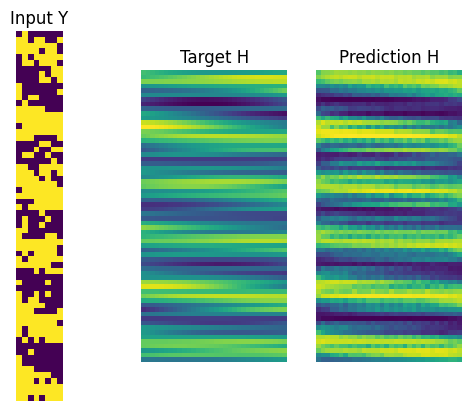

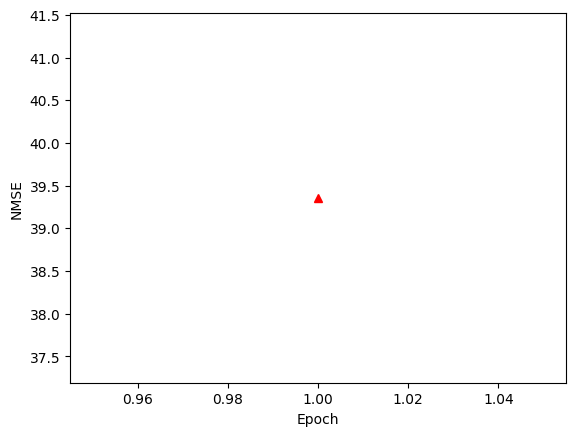

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 34.90928 , Discriminator loss: 0.7108139 , time: 0:03:43.579228
B/E: 103 / 1 , Generator loss: 31.505383 , Discriminator loss: 0.58886313 , time: 0:03:56.250539
B/E: 206 / 1 , Generator loss: 34.663532 , Discriminator loss: 0.29594845 , time: 0:04:08.975800
B/E: 309 / 1 , Generator loss: 25.804262 , Discriminator loss: 0.79728377 , time: 0:04:21.705204
B/E: 412 / 1 , Generator loss: 26.171207 , Discriminator loss: 1.4061168 , time: 0:04:34.216005
B/E: 515 / 1 , Generator loss: 24.188864 , Discriminator loss: 0.6382289 , time: 0:04:46.903504
B/E: 618 / 1 , Generator loss: 19.914434 , Discriminator loss: 0.771461 , time: 0:05:00.740681
B/E: 721 / 1 , Generator loss: 20.230722 , Discriminator loss: 0.9743326 , time: 0:05:13.561815
B/E: 824 / 1 , Generator loss: 19.963552 , Discriminator loss: 0.49586546 , time: 0:05:25.943822
B/E: 927 / 1 , Generator loss: 20.508688 , Discriminator loss: 0.73458755 , time: 0:05:37.942708
B/E: 1030 / 1 , Generato

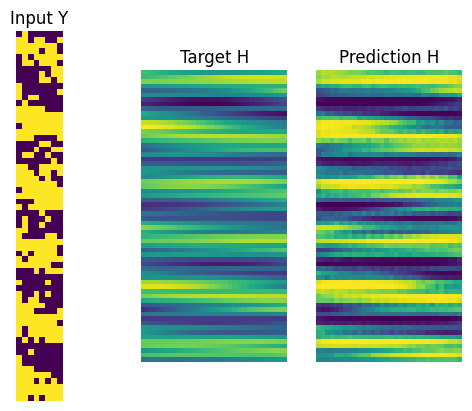

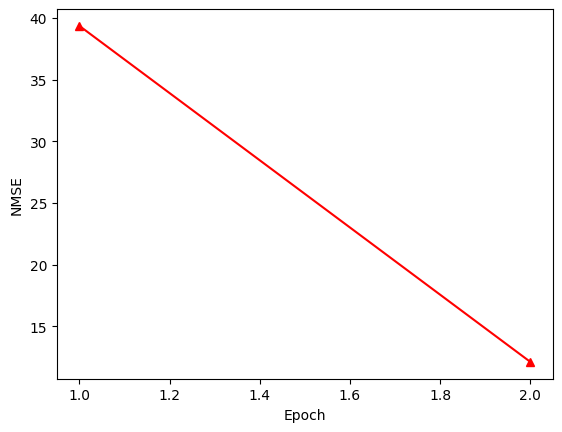

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 19.582533 , Discriminator loss: 0.9748247 , time: 0:06:57.031895
B/E: 103 / 2 , Generator loss: 23.965752 , Discriminator loss: 0.69247156 , time: 0:07:09.917268
B/E: 206 / 2 , Generator loss: 25.31692 , Discriminator loss: 0.51368845 , time: 0:07:22.606627
B/E: 309 / 2 , Generator loss: 15.865031 , Discriminator loss: 1.0530326 , time: 0:07:35.099787
B/E: 412 / 2 , Generator loss: 19.801453 , Discriminator loss: 0.6773772 , time: 0:07:47.761434
B/E: 515 / 2 , Generator loss: 15.750858 , Discriminator loss: 0.8615041 , time: 0:08:00.559528
B/E: 618 / 2 , Generator loss: 14.858846 , Discriminator loss: 0.58568263 , time: 0:08:13.557458
B/E: 721 / 2 , Generator loss: 16.12905 , Discriminator loss: 0.9982537 , time: 0:08:27.552750
B/E: 824 / 2 , Generator loss: 17.21498 , Discriminator loss: 1.480566 , time: 0:08:40.376708
B/E: 927 / 2 , Generator loss: 18.94099 , Discriminator loss: 1.7105088 , time: 0:08:52.877799
B/E: 1030 / 2 , Generator los

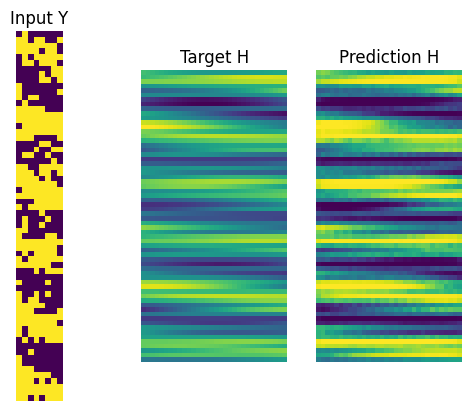

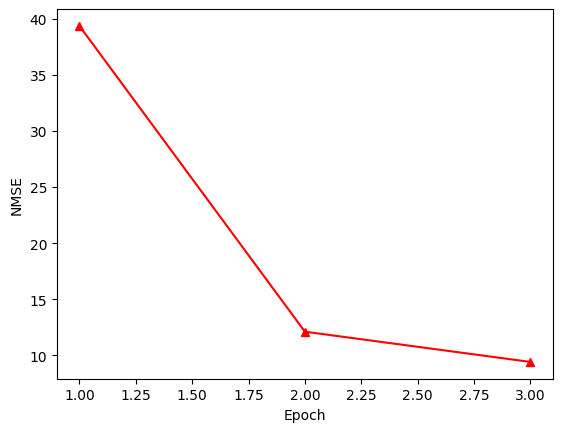

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 15.975434 , Discriminator loss: 1.2442584 , time: 0:10:11.242248
B/E: 103 / 3 , Generator loss: 15.6567135 , Discriminator loss: 0.59840536 , time: 0:10:24.104097
B/E: 206 / 3 , Generator loss: 16.619305 , Discriminator loss: 1.2345235 , time: 0:10:36.870248
B/E: 309 / 3 , Generator loss: 18.180147 , Discriminator loss: 0.41512322 , time: 0:10:49.629708
B/E: 412 / 3 , Generator loss: 21.197235 , Discriminator loss: 0.5515424 , time: 0:11:02.479295
B/E: 515 / 3 , Generator loss: 18.842062 , Discriminator loss: 0.68537545 , time: 0:11:15.251893
B/E: 618 / 3 , Generator loss: 17.01899 , Discriminator loss: 0.23946585 , time: 0:11:28.100411
B/E: 721 / 3 , Generator loss: 17.182558 , Discriminator loss: 0.49699333 , time: 0:11:40.858687
B/E: 824 / 3 , Generator loss: 15.083408 , Discriminator loss: 0.5169145 , time: 0:11:55.142209
B/E: 927 / 3 , Generator loss: 13.485606 , Discriminator loss: 0.6741651 , time: 0:12:08.254955
B/E: 1030 / 3 , Genera

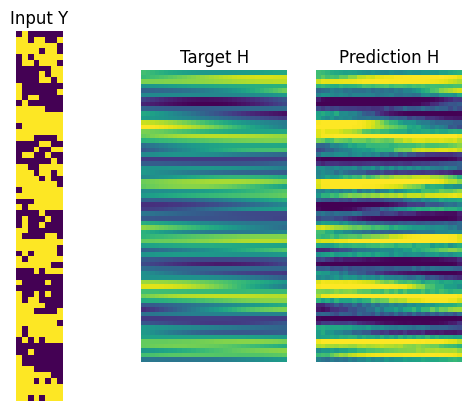

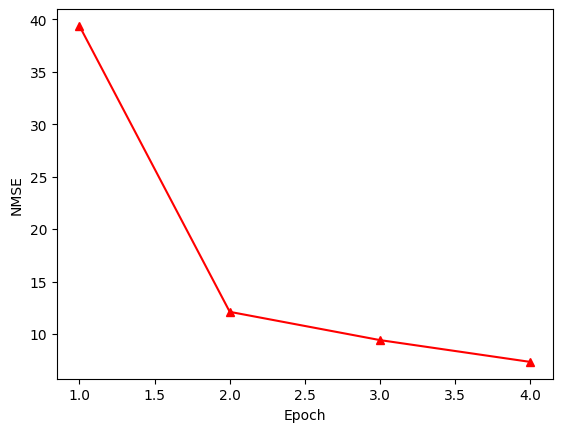

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 18.22043 , Discriminator loss: 2.6859362 , time: 0:13:27.005682
B/E: 103 / 4 , Generator loss: 14.2483225 , Discriminator loss: 0.36420202 , time: 0:13:40.081693
B/E: 206 / 4 , Generator loss: 15.395504 , Discriminator loss: 0.74360394 , time: 0:13:52.945284
B/E: 309 / 4 , Generator loss: 11.612702 , Discriminator loss: 0.34147066 , time: 0:14:05.891392
B/E: 412 / 4 , Generator loss: 17.118261 , Discriminator loss: 1.1380024 , time: 0:14:18.908431
B/E: 515 / 4 , Generator loss: 13.302954 , Discriminator loss: 1.3393869 , time: 0:14:31.956328
B/E: 618 / 4 , Generator loss: 11.508824 , Discriminator loss: 0.29561302 , time: 0:14:44.830649
B/E: 721 / 4 , Generator loss: 13.831424 , Discriminator loss: 3.5105243 , time: 0:14:57.860515
B/E: 824 / 4 , Generator loss: 16.195854 , Discriminator loss: 0.43153793 , time: 0:15:10.788234
B/E: 927 / 4 , Generator loss: 17.453417 , Discriminator loss: 0.13827324 , time: 0:15:24.637564
B/E: 1030 / 4 , Gener

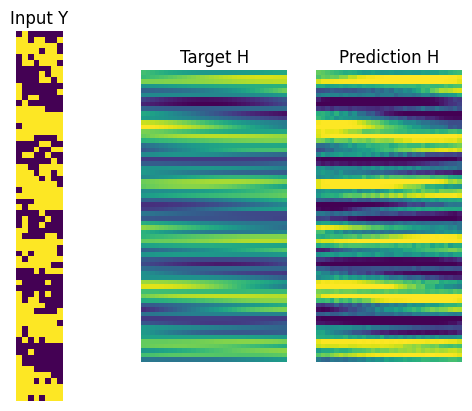

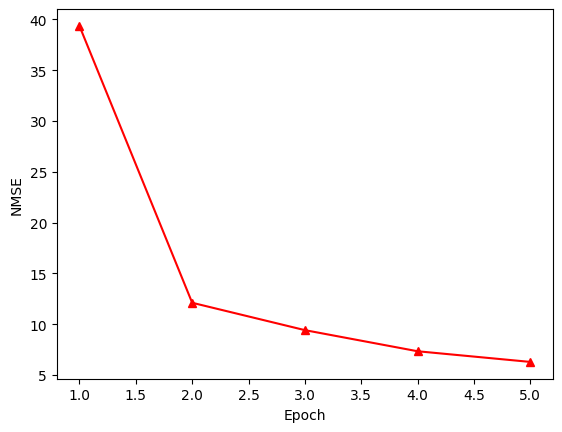

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 18.289627 , Discriminator loss: 0.5223273 , time: 0:16:44.004008
B/E: 103 / 5 , Generator loss: 19.97532 , Discriminator loss: 0.29861253 , time: 0:17:03.351128
B/E: 206 / 5 , Generator loss: 15.457313 , Discriminator loss: 1.0151364 , time: 0:17:16.698024
B/E: 309 / 5 , Generator loss: 13.654011 , Discriminator loss: 0.5367849 , time: 0:17:29.864183
B/E: 412 / 5 , Generator loss: 15.092664 , Discriminator loss: 0.15153825 , time: 0:17:43.337783
B/E: 515 / 5 , Generator loss: 12.796077 , Discriminator loss: 1.0904031 , time: 0:17:56.557971
B/E: 618 / 5 , Generator loss: 19.185358 , Discriminator loss: 0.17333788 , time: 0:18:09.567290
B/E: 721 / 5 , Generator loss: 13.678714 , Discriminator loss: 0.49326944 , time: 0:18:22.448587
B/E: 824 / 5 , Generator loss: 15.092854 , Discriminator loss: 0.24127516 , time: 0:18:36.171911
B/E: 927 / 5 , Generator loss: 15.308212 , Discriminator loss: 0.1694853 , time: 0:18:49.251886
B/E: 1030 / 5 , Generat

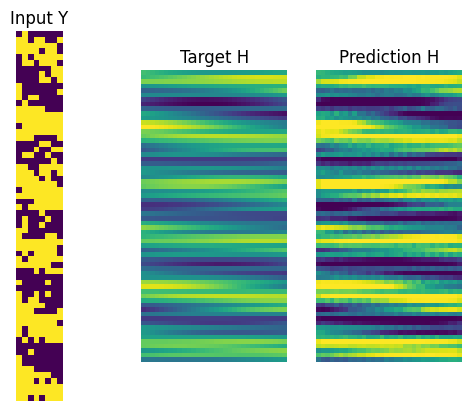

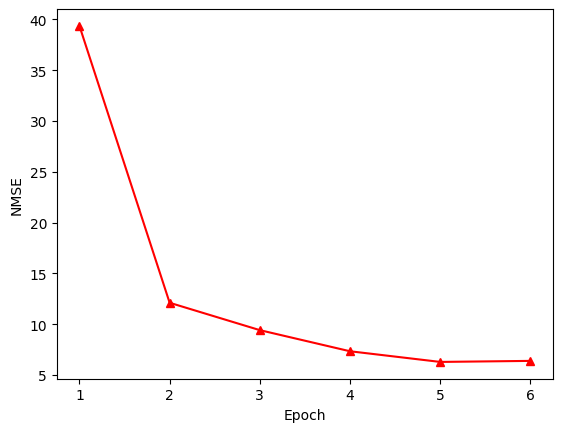

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 16.001154 , Discriminator loss: 0.8793708 , time: 0:20:10.298516
B/E: 103 / 6 , Generator loss: 13.763916 , Discriminator loss: 0.62836945 , time: 0:20:23.653472
B/E: 206 / 6 , Generator loss: 11.221317 , Discriminator loss: 0.59483397 , time: 0:20:36.595360
B/E: 309 / 6 , Generator loss: 13.567709 , Discriminator loss: 0.12163362 , time: 0:20:49.559135
B/E: 412 / 6 , Generator loss: 13.294027 , Discriminator loss: 0.17141372 , time: 0:21:02.829266
B/E: 515 / 6 , Generator loss: 17.34027 , Discriminator loss: 1.5677209 , time: 0:21:16.047206
B/E: 618 / 6 , Generator loss: 14.393613 , Discriminator loss: 0.93432397 , time: 0:21:29.019994
B/E: 721 / 6 , Generator loss: 17.688091 , Discriminator loss: 0.20941877 , time: 0:21:41.976880
B/E: 824 / 6 , Generator loss: 12.952036 , Discriminator loss: 0.51184946 , time: 0:21:55.131459
B/E: 927 / 6 , Generator loss: 12.255107 , Discriminator loss: 0.47615483 , time: 0:22:08.287724
B/E: 1030 / 6 , Gene

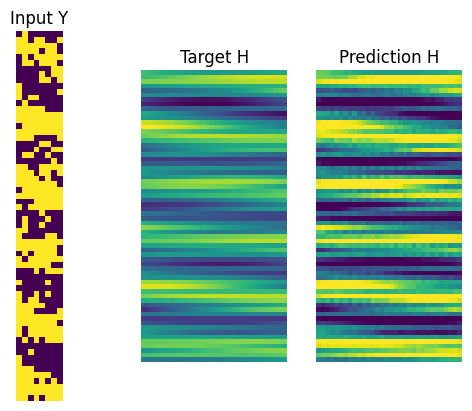

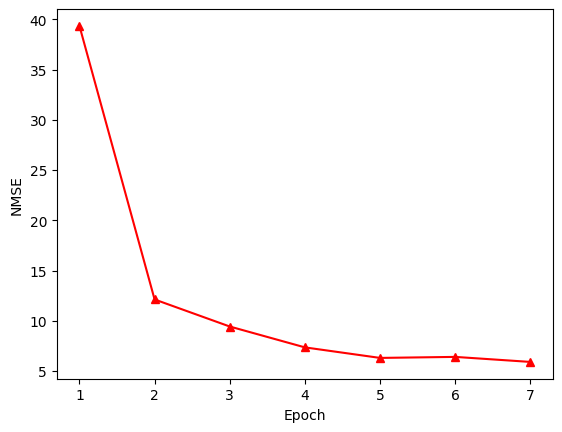

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 12.014519 , Discriminator loss: 1.4081273 , time: 0:00:00.602253
B/E: 103 / 0 , Generator loss: 15.125453 , Discriminator loss: 0.08176743 , time: 0:00:13.275423
B/E: 206 / 0 , Generator loss: 11.91282 , Discriminator loss: 0.6261985 , time: 0:00:25.996700
B/E: 309 / 0 , Generator loss: 15.125104 , Discriminator loss: 0.15616387 , time: 0:00:38.712955
B/E: 412 / 0 , Generator loss: 12.525821 , Discriminator loss: 0.70063084 , time: 0:00:51.038572
B/E: 515 / 0 , Generator loss: 11.949717 , Discriminator loss: 0.5791713 , time: 0:01:03.316502
B/E: 618 / 0 , Generator loss: 14.121603 , Discriminator loss: 0.2559167 , time: 0:01:15.760147
B/E: 721 / 0 , Generator loss: 17.85083 , Discriminator loss: 1.3670636 , time: 0:01:28.316477
B/E: 824 / 0 , Generator loss: 14.499326 , Discriminator loss: 0.6226618 , time: 0:01:41.143876
B/E: 927 / 0 , Generator loss: 14.219886 , Discriminator loss: 1.0805662 , time: 0:01:53.803458
B/E: 1030 / 0 , Generator 

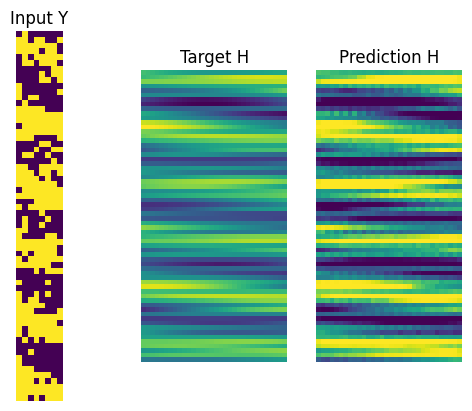

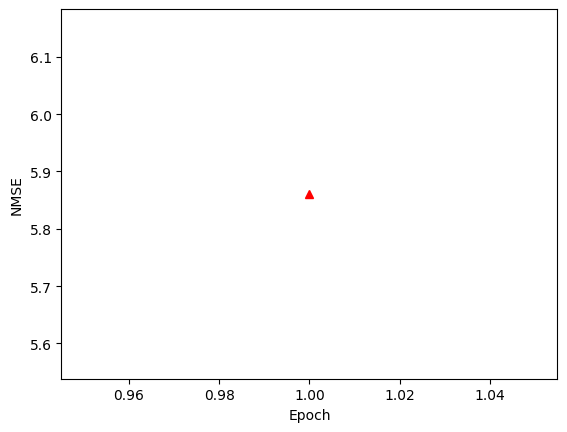

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 13.478288 , Discriminator loss: 1.5256233 , time: 0:03:14.836522
B/E: 103 / 1 , Generator loss: 13.760849 , Discriminator loss: 0.066627845 , time: 0:03:27.763817
B/E: 206 / 1 , Generator loss: 10.403619 , Discriminator loss: 2.7330372 , time: 0:03:41.338562
B/E: 309 / 1 , Generator loss: 10.962622 , Discriminator loss: 1.0144844 , time: 0:03:54.390104
B/E: 412 / 1 , Generator loss: 16.060913 , Discriminator loss: 0.32956883 , time: 0:04:07.540244
B/E: 515 / 1 , Generator loss: 14.385583 , Discriminator loss: 0.58454186 , time: 0:04:20.828752
B/E: 618 / 1 , Generator loss: 13.9276705 , Discriminator loss: 0.10804784 , time: 0:04:33.547895
B/E: 721 / 1 , Generator loss: 12.438723 , Discriminator loss: 0.25008014 , time: 0:04:46.049691
B/E: 824 / 1 , Generator loss: 15.107579 , Discriminator loss: 0.16609424 , time: 0:04:58.722801
B/E: 927 / 1 , Generator loss: 13.132364 , Discriminator loss: 0.08964355 , time: 0:05:11.369534
B/E: 1030 / 1 , Ge

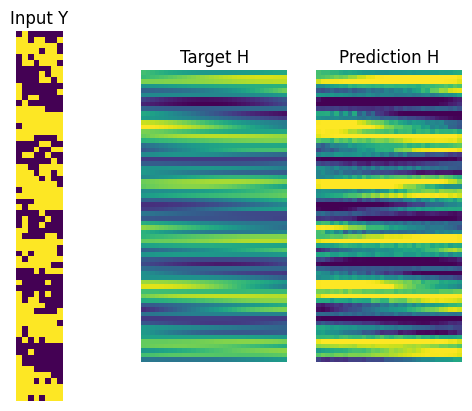

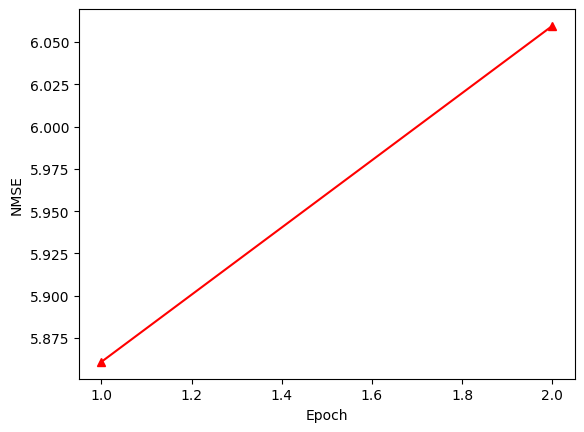

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 11.688395 , Discriminator loss: 2.4290154 , time: 0:06:33.011208
B/E: 103 / 2 , Generator loss: 12.864489 , Discriminator loss: 2.9009476 , time: 0:06:46.124535
B/E: 206 / 2 , Generator loss: 16.228697 , Discriminator loss: 0.0428305 , time: 0:06:59.141271
B/E: 309 / 2 , Generator loss: 14.601086 , Discriminator loss: 0.49386606 , time: 0:07:11.873415
B/E: 412 / 2 , Generator loss: 15.48039 , Discriminator loss: 0.0835771 , time: 0:07:24.748110
B/E: 515 / 2 , Generator loss: 9.817164 , Discriminator loss: 1.6070019 , time: 0:07:37.400624
B/E: 618 / 2 , Generator loss: 14.365885 , Discriminator loss: 0.29605696 , time: 0:07:50.230199
B/E: 721 / 2 , Generator loss: 13.608909 , Discriminator loss: 0.09063275 , time: 0:08:03.062775
B/E: 824 / 2 , Generator loss: 15.123034 , Discriminator loss: 0.03342685 , time: 0:08:15.734417
B/E: 927 / 2 , Generator loss: 16.390717 , Discriminator loss: 0.13658346 , time: 0:08:28.503193
B/E: 1030 / 2 , Generato

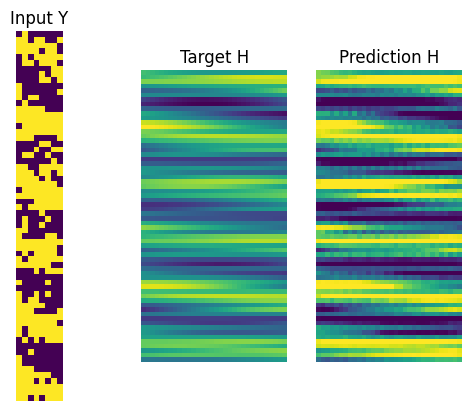

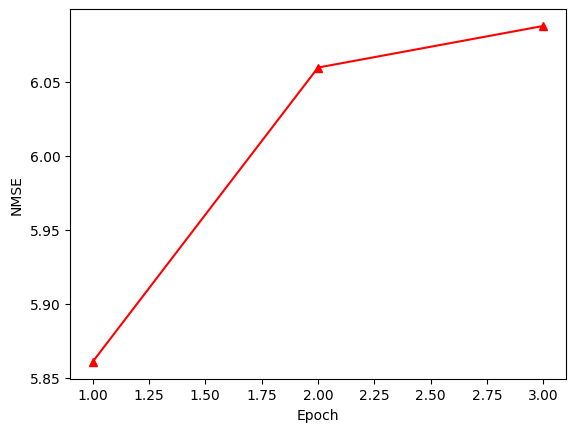

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 13.260134 , Discriminator loss: 0.08854216 , time: 0:09:47.063052
B/E: 103 / 3 , Generator loss: 10.572821 , Discriminator loss: 1.13446 , time: 0:10:01.550229
B/E: 206 / 3 , Generator loss: 12.371669 , Discriminator loss: 1.9005114 , time: 0:10:14.557923
B/E: 309 / 3 , Generator loss: 13.19899 , Discriminator loss: 0.26419458 , time: 0:10:27.196424
B/E: 412 / 3 , Generator loss: 11.678832 , Discriminator loss: 0.29117125 , time: 0:10:39.980044
B/E: 515 / 3 , Generator loss: 12.422479 , Discriminator loss: 0.5062902 , time: 0:10:53.109176
B/E: 618 / 3 , Generator loss: 12.717915 , Discriminator loss: 0.11579839 , time: 0:11:06.091319
B/E: 721 / 3 , Generator loss: 16.22946 , Discriminator loss: 0.06027065 , time: 0:11:19.128841
B/E: 824 / 3 , Generator loss: 12.795759 , Discriminator loss: 0.22112863 , time: 0:11:32.278027
B/E: 927 / 3 , Generator loss: 11.954164 , Discriminator loss: 0.23605107 , time: 0:11:45.382199
B/E: 1030 / 3 , Generato

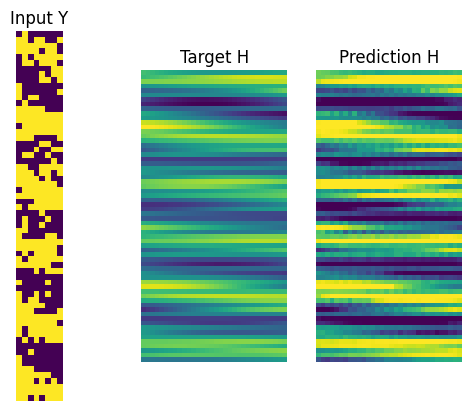

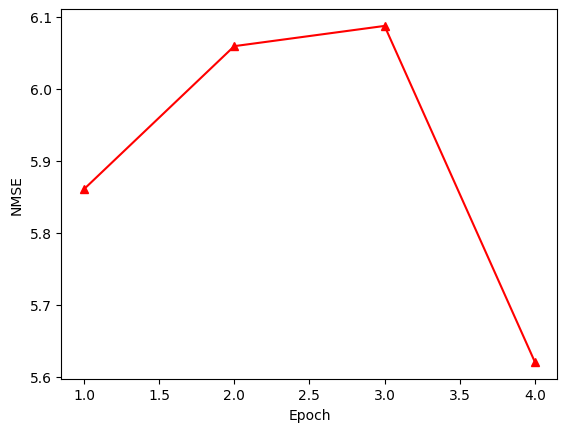

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 9.0793915 , Discriminator loss: 2.2469242 , time: 0:13:05.852648
B/E: 103 / 4 , Generator loss: 12.433386 , Discriminator loss: 1.3698971 , time: 0:13:18.881303
B/E: 206 / 4 , Generator loss: 11.516972 , Discriminator loss: 1.0225179 , time: 0:13:32.515182
B/E: 309 / 4 , Generator loss: 16.942272 , Discriminator loss: 0.015598547 , time: 0:13:46.088498
B/E: 412 / 4 , Generator loss: 11.769648 , Discriminator loss: 0.8460703 , time: 0:13:59.002552
B/E: 515 / 4 , Generator loss: 14.145261 , Discriminator loss: 0.2756354 , time: 0:14:11.681120
B/E: 618 / 4 , Generator loss: 12.7178545 , Discriminator loss: 0.45180464 , time: 0:14:24.150143
B/E: 721 / 4 , Generator loss: 13.464175 , Discriminator loss: 0.46423492 , time: 0:14:36.559353
B/E: 824 / 4 , Generator loss: 15.804453 , Discriminator loss: 0.28058726 , time: 0:14:49.392263
B/E: 927 / 4 , Generator loss: 14.40961 , Discriminator loss: 1.4467198 , time: 0:15:02.257850
B/E: 1030 / 4 , Genera

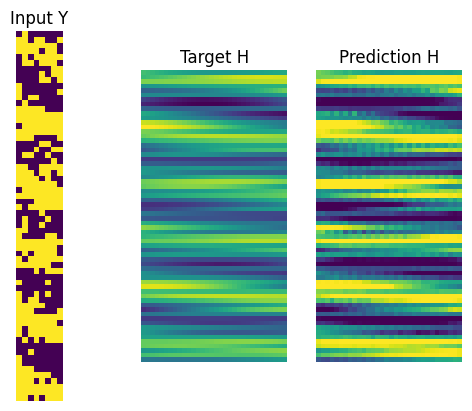

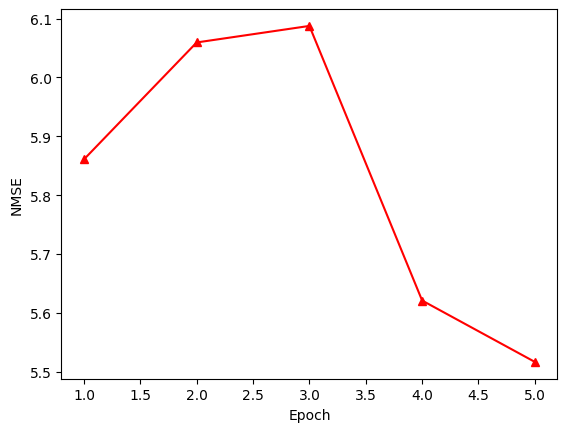

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 14.404104 , Discriminator loss: 0.061605163 , time: 0:16:21.843169
B/E: 103 / 5 , Generator loss: 18.25074 , Discriminator loss: 2.2304647 , time: 0:16:34.612000
B/E: 206 / 5 , Generator loss: 12.511245 , Discriminator loss: 0.11927253 , time: 0:16:47.398151
B/E: 309 / 5 , Generator loss: 14.266644 , Discriminator loss: 0.028621513 , time: 0:17:00.148978
B/E: 412 / 5 , Generator loss: 17.192245 , Discriminator loss: 0.010451896 , time: 0:17:14.123471
B/E: 515 / 5 , Generator loss: 17.71931 , Discriminator loss: 1.6397896 , time: 0:17:27.392113
B/E: 618 / 5 , Generator loss: 9.827506 , Discriminator loss: 0.6314035 , time: 0:17:40.158968
B/E: 721 / 5 , Generator loss: 10.066914 , Discriminator loss: 0.46637022 , time: 0:17:52.959886
B/E: 824 / 5 , Generator loss: 17.346912 , Discriminator loss: 0.096535936 , time: 0:18:05.108960
B/E: 927 / 5 , Generator loss: 12.202545 , Discriminator loss: 0.24362914 , time: 0:18:17.403191
B/E: 1030 / 5 , Gen

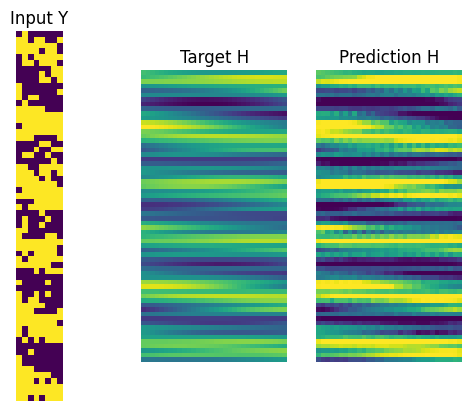

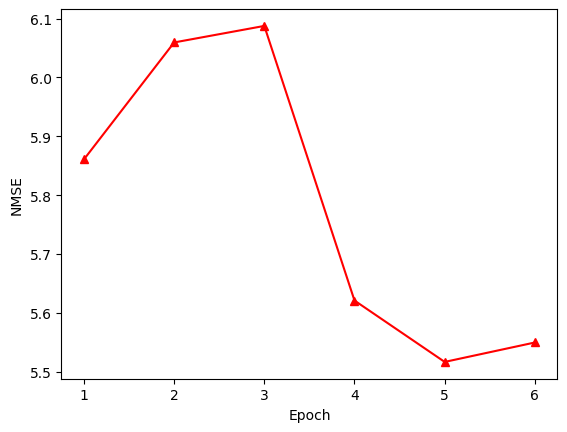

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 15.417994 , Discriminator loss: 0.06964495 , time: 0:19:36.614262
B/E: 103 / 6 , Generator loss: 12.585736 , Discriminator loss: 0.3754408 , time: 0:19:49.530108
B/E: 206 / 6 , Generator loss: 16.18311 , Discriminator loss: 0.08307534 , time: 0:20:02.420135
B/E: 309 / 6 , Generator loss: 15.287685 , Discriminator loss: 0.47538665 , time: 0:20:15.261265
B/E: 412 / 6 , Generator loss: 14.679352 , Discriminator loss: 0.61686784 , time: 0:20:28.234442
B/E: 515 / 6 , Generator loss: 17.654358 , Discriminator loss: 0.01540466 , time: 0:20:41.021122
B/E: 618 / 6 , Generator loss: 15.212818 , Discriminator loss: 0.28823587 , time: 0:20:54.820442
B/E: 721 / 6 , Generator loss: 15.216587 , Discriminator loss: 0.6971878 , time: 0:21:08.116426
B/E: 824 / 6 , Generator loss: 15.424177 , Discriminator loss: 0.020011695 , time: 0:21:20.905903
B/E: 927 / 6 , Generator loss: 13.345742 , Discriminator loss: 0.61558396 , time: 0:21:33.621434
B/E: 1030 / 6 , Gen

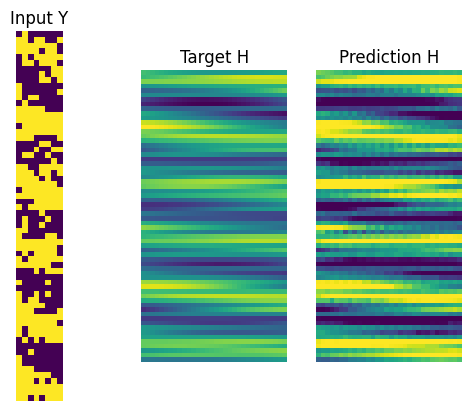

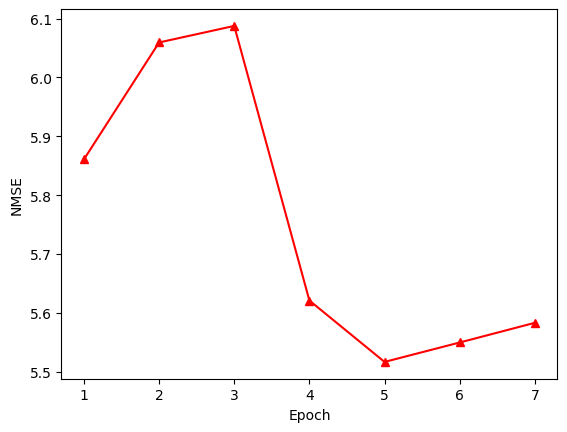

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 15.637695 , Discriminator loss: 0.18700863 , time: 0:00:00.577105
B/E: 103 / 0 , Generator loss: 16.195553 , Discriminator loss: 0.027842656 , time: 0:00:13.557110
B/E: 206 / 0 , Generator loss: 13.5884285 , Discriminator loss: 0.1092481 , time: 0:00:26.357389
B/E: 309 / 0 , Generator loss: 16.658762 , Discriminator loss: 0.103791155 , time: 0:00:39.386832
B/E: 412 / 0 , Generator loss: 15.515593 , Discriminator loss: 0.3661716 , time: 0:00:52.242968
B/E: 515 / 0 , Generator loss: 18.25172 , Discriminator loss: 0.007819399 , time: 0:01:05.096733
B/E: 618 / 0 , Generator loss: 13.920416 , Discriminator loss: 0.07271505 , time: 0:01:17.873202
B/E: 721 / 0 , Generator loss: 12.423908 , Discriminator loss: 0.5485362 , time: 0:01:30.625642
B/E: 824 / 0 , Generator loss: 13.960715 , Discriminator loss: 0.6772395 , time: 0:01:44.236428
B/E: 927 / 0 , Generator loss: 14.607504 , Discriminator loss: 0.023681344 , time: 0:01:57.527084
B/E: 1030 / 0 , G

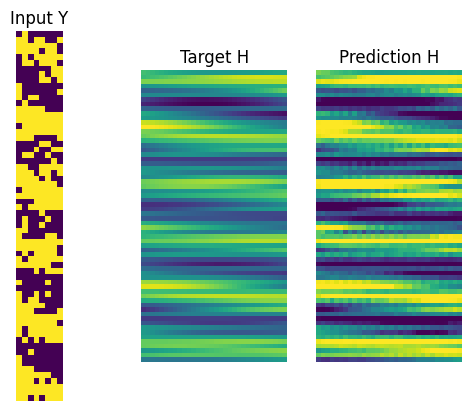

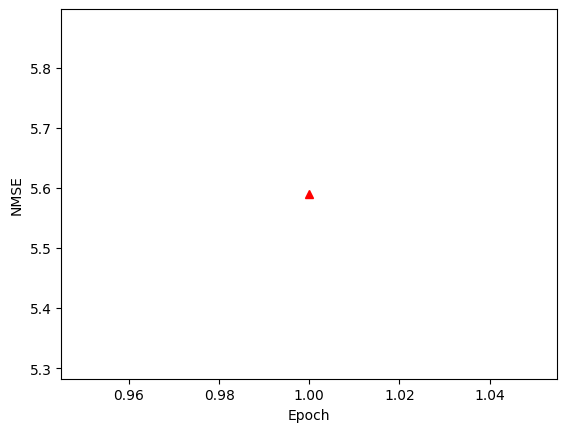

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 11.157692 , Discriminator loss: 0.9585921 , time: 0:03:16.998296
B/E: 103 / 1 , Generator loss: 13.71372 , Discriminator loss: 0.1746233 , time: 0:03:29.843677
B/E: 206 / 1 , Generator loss: 17.18507 , Discriminator loss: 0.007322477 , time: 0:03:42.614800
B/E: 309 / 1 , Generator loss: 11.5469265 , Discriminator loss: 0.98686695 , time: 0:03:55.679925
B/E: 412 / 1 , Generator loss: 17.345161 , Discriminator loss: 0.0030908408 , time: 0:04:08.623635
B/E: 515 / 1 , Generator loss: 12.028397 , Discriminator loss: 1.9208585 , time: 0:04:21.532895
B/E: 618 / 1 , Generator loss: 14.7378845 , Discriminator loss: 0.03331947 , time: 0:04:34.364943
B/E: 721 / 1 , Generator loss: 16.56404 , Discriminator loss: 0.023844687 , time: 0:04:47.267534
B/E: 824 / 1 , Generator loss: 19.552612 , Discriminator loss: 0.0051399516 , time: 0:05:00.322968
B/E: 927 / 1 , Generator loss: 10.209224 , Discriminator loss: 5.028775 , time: 0:05:13.121410
B/E: 1030 / 1 , G

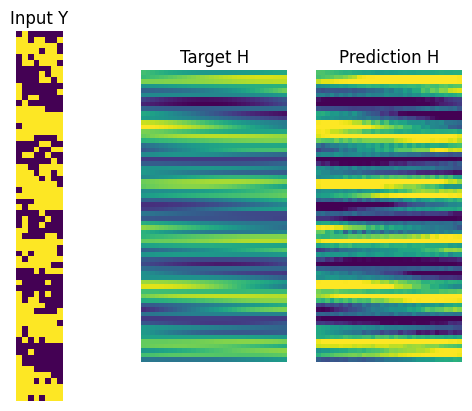

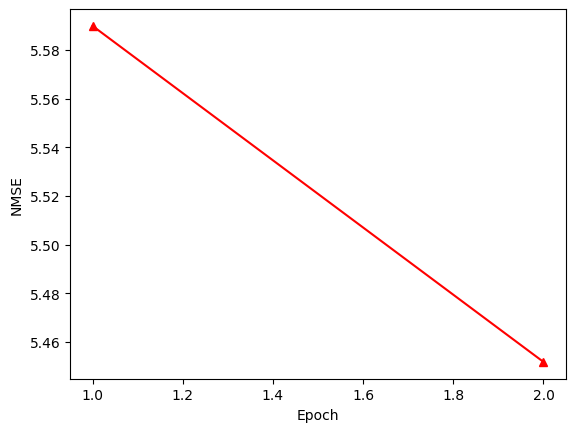

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 18.900532 , Discriminator loss: 0.036903523 , time: 0:06:34.153343
B/E: 103 / 2 , Generator loss: 17.490194 , Discriminator loss: 0.046036914 , time: 0:06:46.821131
B/E: 206 / 2 , Generator loss: 14.3926525 , Discriminator loss: 0.043008115 , time: 0:06:59.264208
B/E: 309 / 2 , Generator loss: 11.174141 , Discriminator loss: 0.33595252 , time: 0:07:11.910580
B/E: 412 / 2 , Generator loss: 16.970657 , Discriminator loss: 0.5733124 , time: 0:07:24.658962
B/E: 515 / 2 , Generator loss: 14.370613 , Discriminator loss: 0.047421113 , time: 0:07:37.430897
B/E: 618 / 2 , Generator loss: 13.603554 , Discriminator loss: 0.3385344 , time: 0:07:50.458010
B/E: 721 / 2 , Generator loss: 14.60298 , Discriminator loss: 0.30688807 , time: 0:08:03.383537
B/E: 824 / 2 , Generator loss: 14.445265 , Discriminator loss: 0.06223117 , time: 0:08:16.365802
B/E: 927 / 2 , Generator loss: 11.069206 , Discriminator loss: 0.63683313 , time: 0:08:29.204027
B/E: 1030 / 2 ,

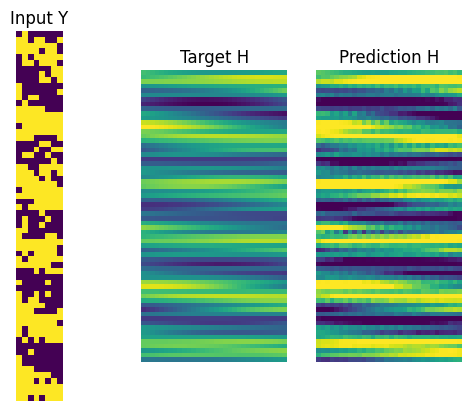

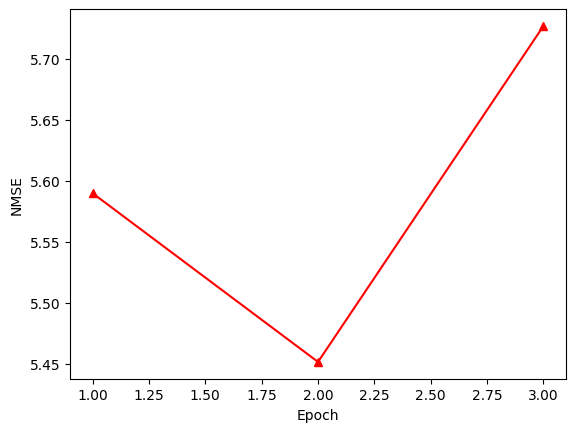

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 16.037226 , Discriminator loss: 0.016980063 , time: 0:09:50.410919
B/E: 103 / 3 , Generator loss: 14.797506 , Discriminator loss: 0.17022267 , time: 0:10:03.374113
B/E: 206 / 3 , Generator loss: 14.118543 , Discriminator loss: 0.04471876 , time: 0:10:16.316638
B/E: 309 / 3 , Generator loss: 13.452129 , Discriminator loss: 0.08287007 , time: 0:10:29.121930
B/E: 412 / 3 , Generator loss: 11.867976 , Discriminator loss: 0.12237132 , time: 0:10:42.255398
B/E: 515 / 3 , Generator loss: 14.049598 , Discriminator loss: 0.10303733 , time: 0:10:54.693878
B/E: 618 / 3 , Generator loss: 13.239528 , Discriminator loss: 0.077295884 , time: 0:11:07.176819
B/E: 721 / 3 , Generator loss: 17.83797 , Discriminator loss: 0.0055576544 , time: 0:11:19.532849
B/E: 824 / 3 , Generator loss: 18.00146 , Discriminator loss: 0.015910663 , time: 0:11:32.259694
B/E: 927 / 3 , Generator loss: 16.498974 , Discriminator loss: 0.008755657 , time: 0:11:45.167368
B/E: 1030 / 3

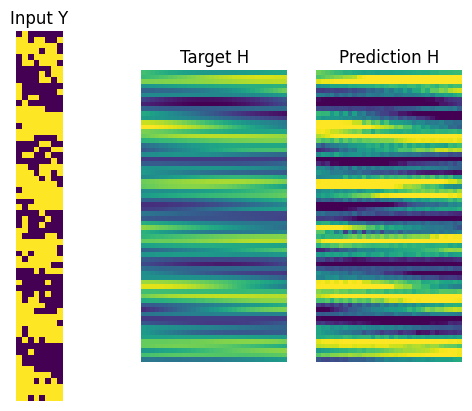

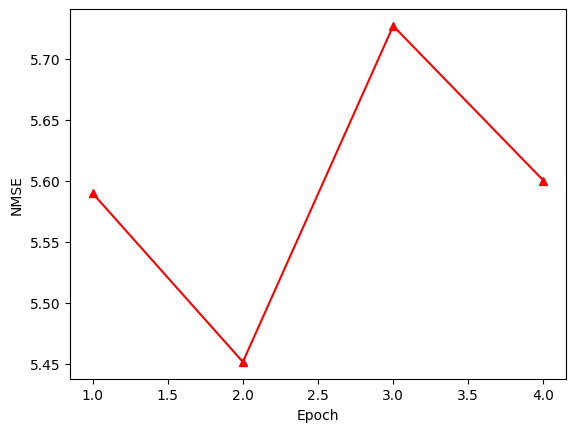

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 15.764243 , Discriminator loss: 0.009389747 , time: 0:13:06.139311
B/E: 103 / 4 , Generator loss: 11.674498 , Discriminator loss: 0.3368592 , time: 0:13:19.244967
B/E: 206 / 4 , Generator loss: 17.544617 , Discriminator loss: 0.0060044713 , time: 0:13:31.939286
B/E: 309 / 4 , Generator loss: 12.91311 , Discriminator loss: 0.18655975 , time: 0:13:44.796476
B/E: 412 / 4 , Generator loss: 15.229204 , Discriminator loss: 0.0107996585 , time: 0:13:57.467300
B/E: 515 / 4 , Generator loss: 18.144554 , Discriminator loss: 0.40558493 , time: 0:14:10.270913
B/E: 618 / 4 , Generator loss: 17.064987 , Discriminator loss: 0.0024928153 , time: 0:14:23.221566
B/E: 721 / 4 , Generator loss: 14.883207 , Discriminator loss: 0.037330896 , time: 0:14:35.956403
B/E: 824 / 4 , Generator loss: 16.669344 , Discriminator loss: 0.019039117 , time: 0:14:48.019730
B/E: 927 / 4 , Generator loss: 11.639147 , Discriminator loss: 2.4997244 , time: 0:15:00.582717
B/E: 1030 /

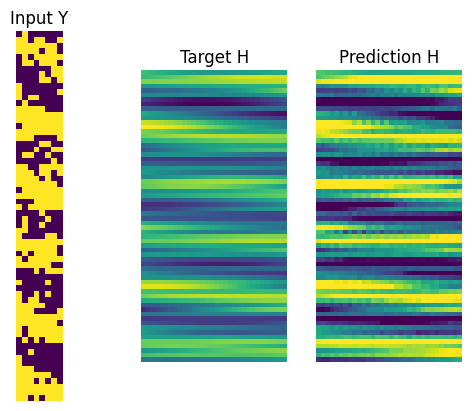

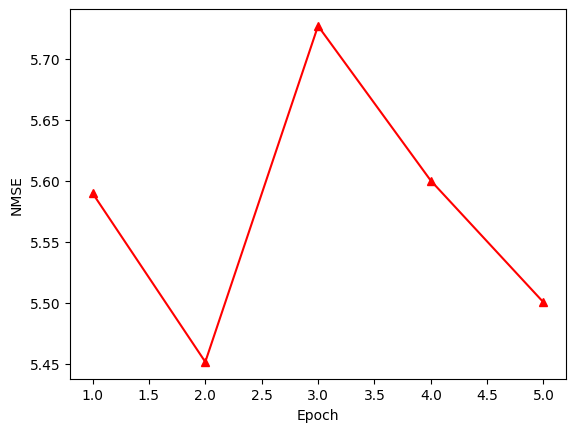

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 13.458143 , Discriminator loss: 0.20340595 , time: 0:16:21.183470
B/E: 103 / 5 , Generator loss: 12.025835 , Discriminator loss: 0.19512928 , time: 0:16:34.184862
B/E: 206 / 5 , Generator loss: 18.224934 , Discriminator loss: 0.2205912 , time: 0:16:48.636938
B/E: 309 / 5 , Generator loss: 13.54974 , Discriminator loss: 0.11575471 , time: 0:17:01.469669
B/E: 412 / 5 , Generator loss: 11.596058 , Discriminator loss: 5.2842264 , time: 0:17:14.351974
B/E: 515 / 5 , Generator loss: 13.045528 , Discriminator loss: 0.04499157 , time: 0:17:27.288143
B/E: 618 / 5 , Generator loss: 16.360643 , Discriminator loss: 0.04406299 , time: 0:17:40.150074
B/E: 721 / 5 , Generator loss: 14.886248 , Discriminator loss: 0.23649451 , time: 0:17:53.277365
B/E: 824 / 5 , Generator loss: 16.736347 , Discriminator loss: 0.12615937 , time: 0:18:06.323215
B/E: 927 / 5 , Generator loss: 16.571478 , Discriminator loss: 0.008718092 , time: 0:18:19.340839
B/E: 1030 / 5 , Gen

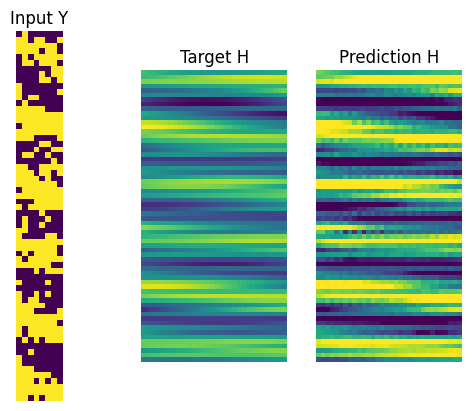

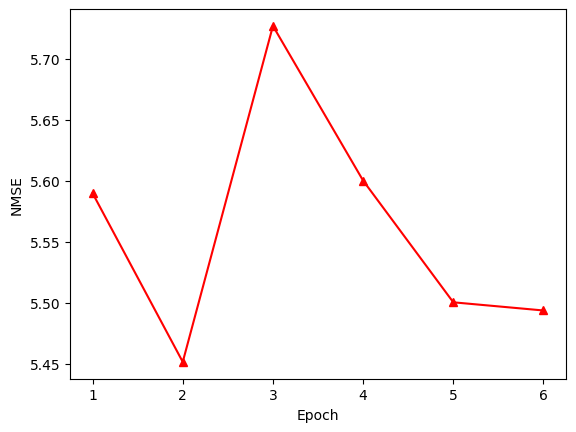

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 14.9804535 , Discriminator loss: 0.76586604 , time: 0:19:38.854606
B/E: 103 / 6 , Generator loss: 17.199657 , Discriminator loss: 0.1472996 , time: 0:19:51.866982
B/E: 206 / 6 , Generator loss: 12.410252 , Discriminator loss: 0.14000161 , time: 0:20:04.776096
B/E: 309 / 6 , Generator loss: 16.961063 , Discriminator loss: 0.0031267167 , time: 0:20:17.843571
B/E: 412 / 6 , Generator loss: 11.658892 , Discriminator loss: 0.36087492 , time: 0:20:31.943157
B/E: 515 / 6 , Generator loss: 9.488244 , Discriminator loss: 1.151807 , time: 0:20:44.768372
B/E: 618 / 6 , Generator loss: 22.853863 , Discriminator loss: 0.2898983 , time: 0:20:57.616608
B/E: 721 / 6 , Generator loss: 18.030567 , Discriminator loss: 0.03399449 , time: 0:21:10.464284
B/E: 824 / 6 , Generator loss: 16.456888 , Discriminator loss: 0.0049200463 , time: 0:21:23.316538
B/E: 927 / 6 , Generator loss: 15.762974 , Discriminator loss: 0.013670767 , time: 0:21:36.099439
B/E: 1030 / 6 , 

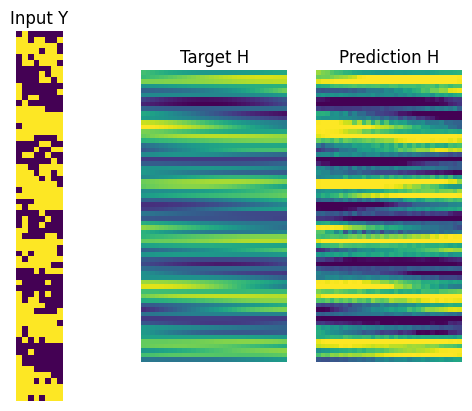

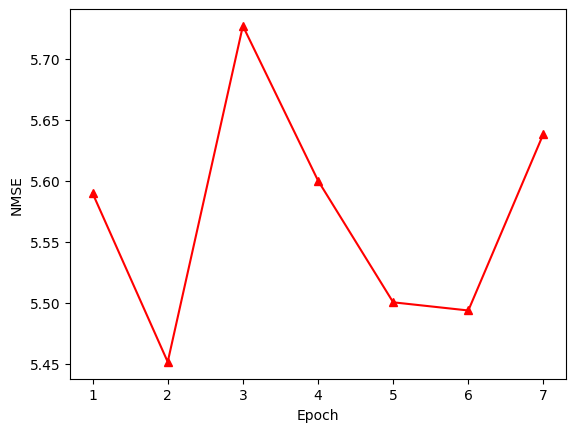

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 16.235592 , Discriminator loss: 0.0059076296 , time: 0:00:00.766896
B/E: 103 / 0 , Generator loss: 16.95839 , Discriminator loss: 0.0032403304 , time: 0:00:13.367226
B/E: 206 / 0 , Generator loss: 15.428732 , Discriminator loss: 0.018284908 , time: 0:00:25.929925
B/E: 309 / 0 , Generator loss: 18.096226 , Discriminator loss: 0.0031853893 , time: 0:00:38.815977
B/E: 412 / 0 , Generator loss: 14.519106 , Discriminator loss: 0.03319448 , time: 0:00:51.747401
B/E: 515 / 0 , Generator loss: 12.895359 , Discriminator loss: 0.12621042 , time: 0:01:04.584911
B/E: 618 / 0 , Generator loss: 15.623314 , Discriminator loss: 0.04339168 , time: 0:01:18.002989
B/E: 721 / 0 , Generator loss: 16.63168 , Discriminator loss: 0.02572677 , time: 0:01:31.602286
B/E: 824 / 0 , Generator loss: 11.738559 , Discriminator loss: 0.18103023 , time: 0:01:44.648627
B/E: 927 / 0 , Generator loss: 14.110741 , Discriminator loss: 0.0206427 , time: 0:01:57.535308
B/E: 1030 / 0

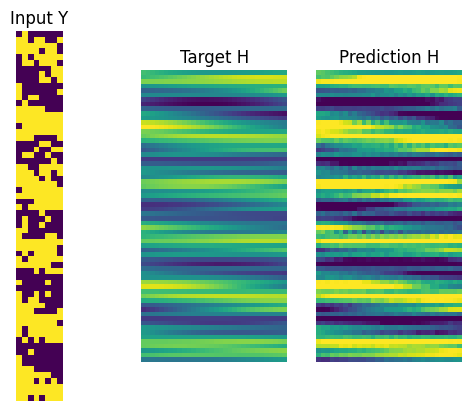

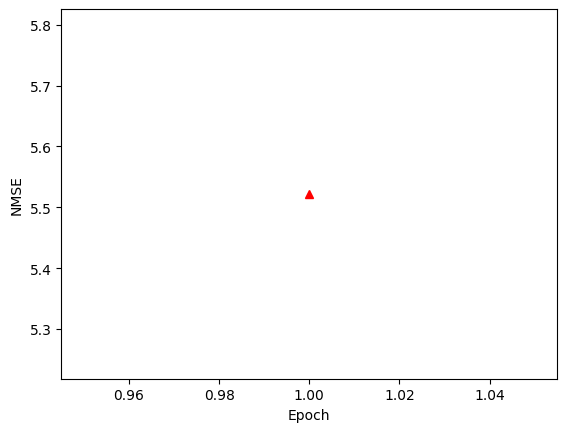

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 15.396847 , Discriminator loss: 0.02243104 , time: 0:03:18.390012
B/E: 103 / 1 , Generator loss: 15.459407 , Discriminator loss: 0.006904411 , time: 0:03:31.444380
B/E: 206 / 1 , Generator loss: 18.385515 , Discriminator loss: 0.06393398 , time: 0:03:44.078787
B/E: 309 / 1 , Generator loss: 12.032028 , Discriminator loss: 0.33066738 , time: 0:03:56.774136
B/E: 412 / 1 , Generator loss: 14.614197 , Discriminator loss: 0.034886137 , time: 0:04:09.017571
B/E: 515 / 1 , Generator loss: 13.893065 , Discriminator loss: 0.049711406 , time: 0:04:21.360570
B/E: 618 / 1 , Generator loss: 17.22909 , Discriminator loss: 0.002481739 , time: 0:04:33.856630
B/E: 721 / 1 , Generator loss: 14.84309 , Discriminator loss: 0.042916276 , time: 0:04:46.510179
B/E: 824 / 1 , Generator loss: 11.16581 , Discriminator loss: 0.19309127 , time: 0:04:59.318845
B/E: 927 / 1 , Generator loss: 14.330185 , Discriminator loss: 0.016566869 , time: 0:05:13.383396
B/E: 1030 / 1 

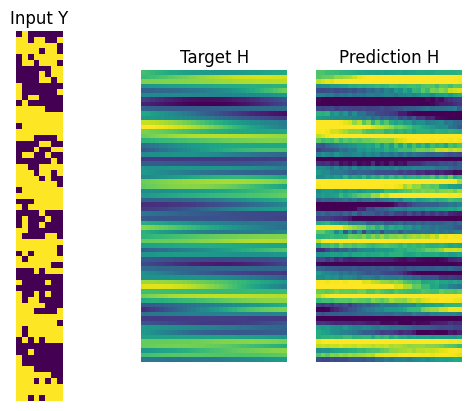

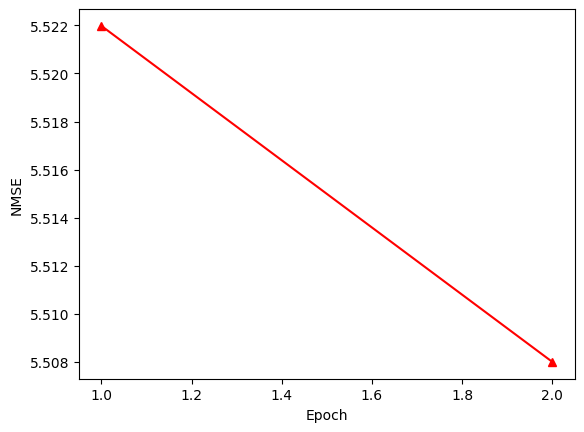

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 11.549868 , Discriminator loss: 0.20203406 , time: 0:06:34.269299
B/E: 103 / 2 , Generator loss: 14.709959 , Discriminator loss: 0.03436147 , time: 0:06:47.216273
B/E: 206 / 2 , Generator loss: 13.304822 , Discriminator loss: 0.049705792 , time: 0:07:00.097398
B/E: 309 / 2 , Generator loss: 18.145416 , Discriminator loss: 0.0065910835 , time: 0:07:12.998592
B/E: 412 / 2 , Generator loss: 10.677925 , Discriminator loss: 3.015414 , time: 0:07:25.815925
B/E: 515 / 2 , Generator loss: 14.220833 , Discriminator loss: 0.037238397 , time: 0:07:38.817975
B/E: 618 / 2 , Generator loss: 17.365084 , Discriminator loss: 0.008301939 , time: 0:07:51.807432
B/E: 721 / 2 , Generator loss: 22.683765 , Discriminator loss: 1.918161 , time: 0:08:04.803128
B/E: 824 / 2 , Generator loss: 17.868885 , Discriminator loss: 0.0026203224 , time: 0:08:17.458454
B/E: 927 / 2 , Generator loss: 15.318327 , Discriminator loss: 0.05620116 , time: 0:08:29.891650
B/E: 1030 / 2 

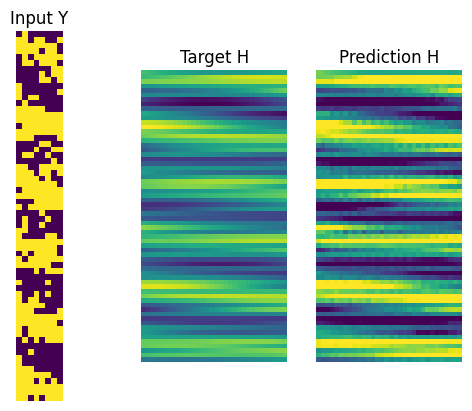

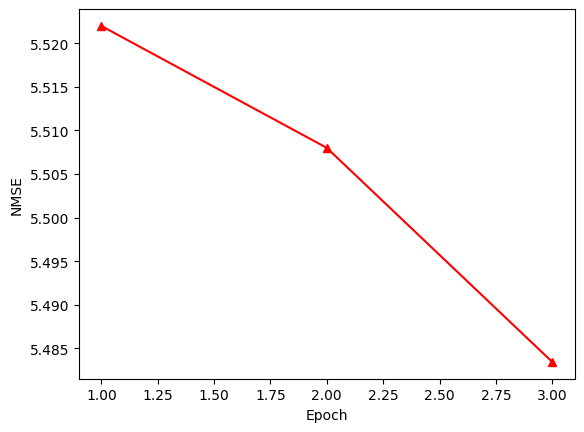

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 17.320807 , Discriminator loss: 0.01064571 , time: 0:09:51.099309
B/E: 103 / 3 , Generator loss: 16.251656 , Discriminator loss: 0.057897005 , time: 0:10:04.181248
B/E: 206 / 3 , Generator loss: 16.300247 , Discriminator loss: 0.0023206212 , time: 0:10:17.135981
B/E: 309 / 3 , Generator loss: 13.903335 , Discriminator loss: 0.027791517 , time: 0:10:30.088305
B/E: 412 / 3 , Generator loss: 15.866146 , Discriminator loss: 0.050247513 , time: 0:10:43.001928
B/E: 515 / 3 , Generator loss: 17.992664 , Discriminator loss: 0.037656385 , time: 0:10:55.860252
B/E: 618 / 3 , Generator loss: 13.505787 , Discriminator loss: 0.08156015 , time: 0:11:08.721145
B/E: 721 / 3 , Generator loss: 18.715183 , Discriminator loss: 0.0024450205 , time: 0:11:21.667147
B/E: 824 / 3 , Generator loss: 15.776297 , Discriminator loss: 0.04213754 , time: 0:11:34.532335
B/E: 927 / 3 , Generator loss: 16.465723 , Discriminator loss: 0.008841323 , time: 0:11:47.389858
B/E: 103

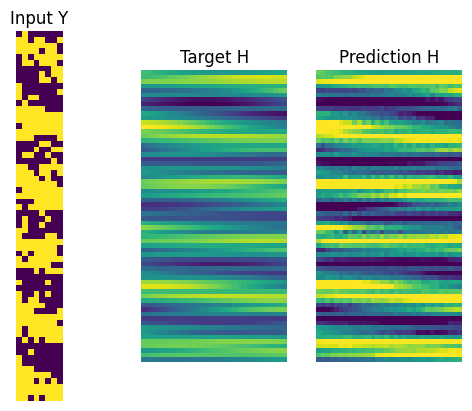

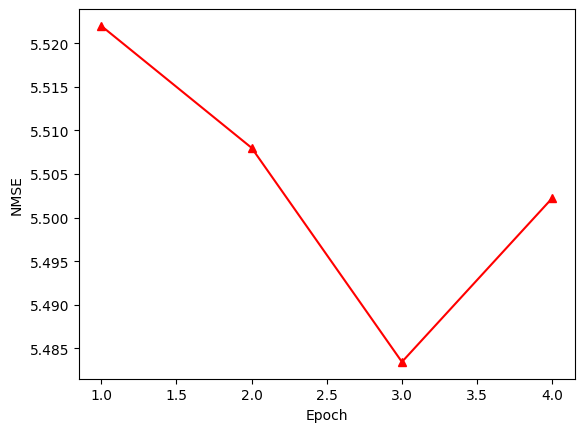

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 13.927021 , Discriminator loss: 0.43270618 , time: 0:13:10.414679
B/E: 103 / 4 , Generator loss: 19.153309 , Discriminator loss: 0.09330422 , time: 0:13:23.459321
B/E: 206 / 4 , Generator loss: 15.614795 , Discriminator loss: 0.0051263133 , time: 0:13:36.471577
B/E: 309 / 4 , Generator loss: 12.986353 , Discriminator loss: 0.06145412 , time: 0:13:48.873981
B/E: 412 / 4 , Generator loss: 17.867062 , Discriminator loss: 0.026896827 , time: 0:14:01.719060
B/E: 515 / 4 , Generator loss: 15.752783 , Discriminator loss: 0.16196918 , time: 0:14:14.636107
B/E: 618 / 4 , Generator loss: 13.391961 , Discriminator loss: 0.26312366 , time: 0:14:27.644884
B/E: 721 / 4 , Generator loss: 17.94997 , Discriminator loss: 0.0013285412 , time: 0:14:40.657567
B/E: 824 / 4 , Generator loss: 15.43112 , Discriminator loss: 0.049406126 , time: 0:14:53.832795
B/E: 927 / 4 , Generator loss: 11.412693 , Discriminator loss: 0.36372343 , time: 0:15:06.864987
B/E: 1030 / 4

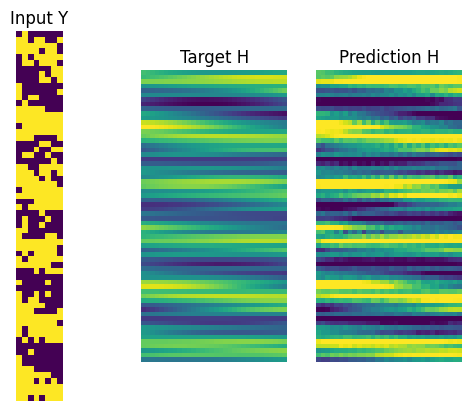

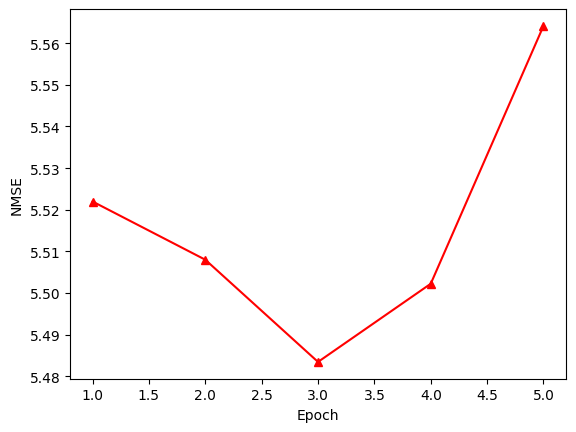

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 14.485865 , Discriminator loss: 0.013666748 , time: 0:16:26.961501
B/E: 103 / 5 , Generator loss: 21.610126 , Discriminator loss: 0.0007308563 , time: 0:16:40.687996
B/E: 206 / 5 , Generator loss: 13.466892 , Discriminator loss: 0.044715222 , time: 0:16:53.933258
B/E: 309 / 5 , Generator loss: 15.856041 , Discriminator loss: 0.025825642 , time: 0:17:07.000893
B/E: 412 / 5 , Generator loss: 16.501537 , Discriminator loss: 0.0024125031 , time: 0:17:20.128989
B/E: 515 / 5 , Generator loss: 16.905113 , Discriminator loss: 0.0035742852 , time: 0:17:32.945467
B/E: 618 / 5 , Generator loss: 17.737629 , Discriminator loss: 0.0043193577 , time: 0:17:45.922107
B/E: 721 / 5 , Generator loss: 14.783127 , Discriminator loss: 0.0135184955 , time: 0:17:58.542498
B/E: 824 / 5 , Generator loss: 19.38136 , Discriminator loss: 0.027814724 , time: 0:18:11.101347
B/E: 927 / 5 , Generator loss: 20.182695 , Discriminator loss: 0.00045381495 , time: 0:18:23.995295
B

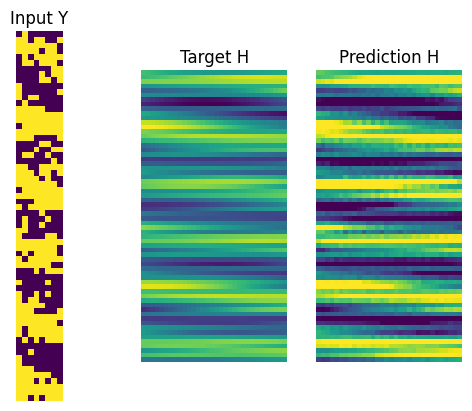

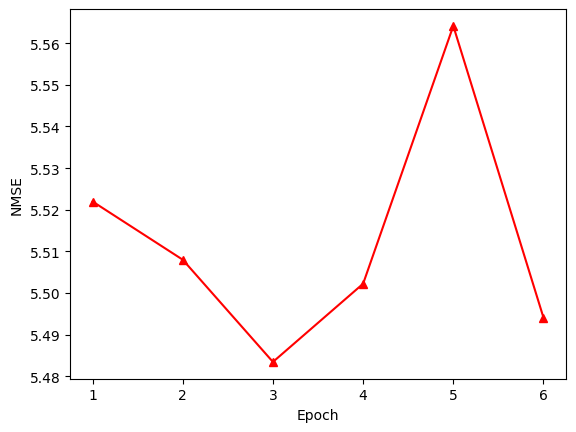

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 13.004994 , Discriminator loss: 0.14037398 , time: 0:19:47.085364
B/E: 103 / 6 , Generator loss: 13.734512 , Discriminator loss: 0.08976349 , time: 0:20:00.115809
B/E: 206 / 6 , Generator loss: 13.755096 , Discriminator loss: 0.030876506 , time: 0:20:13.300843
B/E: 309 / 6 , Generator loss: 9.957034 , Discriminator loss: 0.8773986 , time: 0:20:26.441394
B/E: 412 / 6 , Generator loss: 13.320673 , Discriminator loss: 0.15177023 , time: 0:20:40.647235
B/E: 515 / 6 , Generator loss: 16.373955 , Discriminator loss: 0.005166057 , time: 0:20:53.980620
B/E: 618 / 6 , Generator loss: 21.422913 , Discriminator loss: 0.00048420223 , time: 0:21:07.131828
B/E: 721 / 6 , Generator loss: 12.455315 , Discriminator loss: 0.1507634 , time: 0:21:20.241864
B/E: 824 / 6 , Generator loss: 16.166616 , Discriminator loss: 0.0029584751 , time: 0:21:33.184851
B/E: 927 / 6 , Generator loss: 18.82903 , Discriminator loss: 0.040963516 , time: 0:21:46.341594
B/E: 1030 / 6

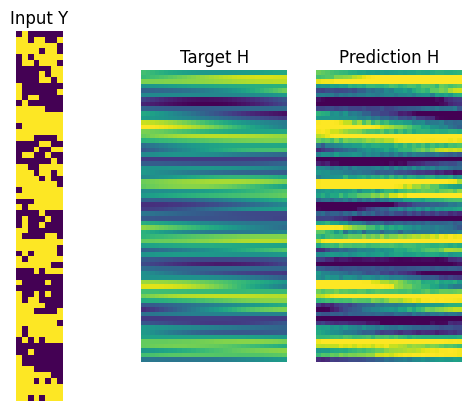

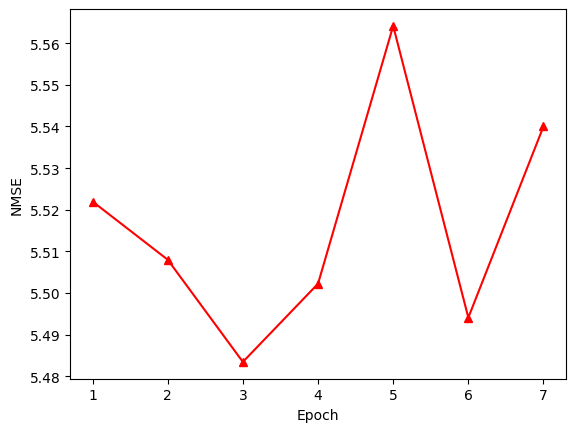

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 16.587406 , Discriminator loss: 0.0024792235 , time: 0:00:00.635492
B/E: 103 / 0 , Generator loss: 14.86441 , Discriminator loss: 0.016866805 , time: 0:00:14.107434
B/E: 206 / 0 , Generator loss: 18.263266 , Discriminator loss: 0.0012522097 , time: 0:00:27.339754
B/E: 309 / 0 , Generator loss: 16.968292 , Discriminator loss: 0.009716937 , time: 0:00:40.626310
B/E: 412 / 0 , Generator loss: 16.914188 , Discriminator loss: 0.0062473845 , time: 0:00:53.783163
B/E: 515 / 0 , Generator loss: 16.05933 , Discriminator loss: 0.04094403 , time: 0:01:06.914503
B/E: 618 / 0 , Generator loss: 19.290644 , Discriminator loss: 0.0020725313 , time: 0:01:19.732991
B/E: 721 / 0 , Generator loss: 14.676006 , Discriminator loss: 0.014935118 , time: 0:01:33.815720
B/E: 824 / 0 , Generator loss: 18.853832 , Discriminator loss: 0.016578348 , time: 0:01:46.876712
B/E: 927 / 0 , Generator loss: 14.868027 , Discriminator loss: 0.014690345 , time: 0:01:59.255975
B/E: 1

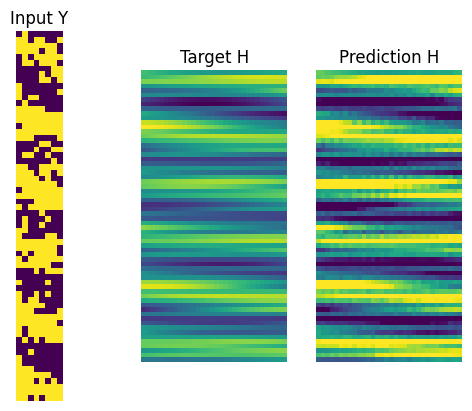

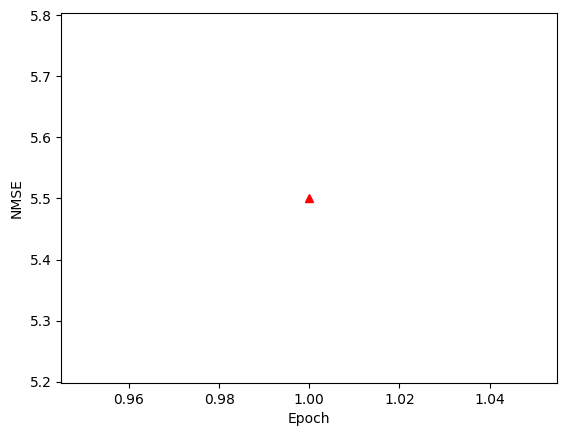

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 15.732449 , Discriminator loss: 0.03824561 , time: 0:03:19.690894
B/E: 103 / 1 , Generator loss: 18.366398 , Discriminator loss: 0.0019099684 , time: 0:03:32.514310
B/E: 206 / 1 , Generator loss: 14.3298 , Discriminator loss: 0.06804359 , time: 0:03:45.515547
B/E: 309 / 1 , Generator loss: 15.685352 , Discriminator loss: 0.014403341 , time: 0:03:58.600903
B/E: 412 / 1 , Generator loss: 19.332449 , Discriminator loss: 0.0010526612 , time: 0:04:11.573396
B/E: 515 / 1 , Generator loss: 16.900599 , Discriminator loss: 0.009332798 , time: 0:04:24.603308
B/E: 618 / 1 , Generator loss: 11.084526 , Discriminator loss: 0.40706876 , time: 0:04:37.733899
B/E: 721 / 1 , Generator loss: 14.6048565 , Discriminator loss: 0.010015677 , time: 0:04:50.710195
B/E: 824 / 1 , Generator loss: 17.310936 , Discriminator loss: 0.006013858 , time: 0:05:03.568445
B/E: 927 / 1 , Generator loss: 19.651375 , Discriminator loss: 0.005299789 , time: 0:05:16.603741
B/E: 1030

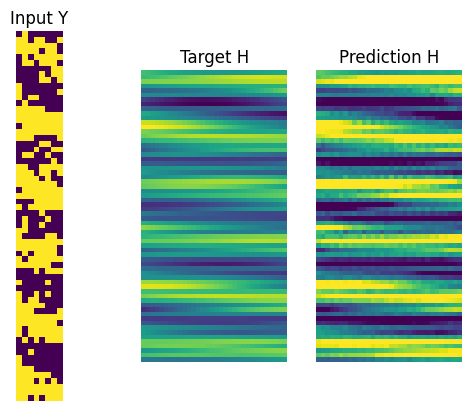

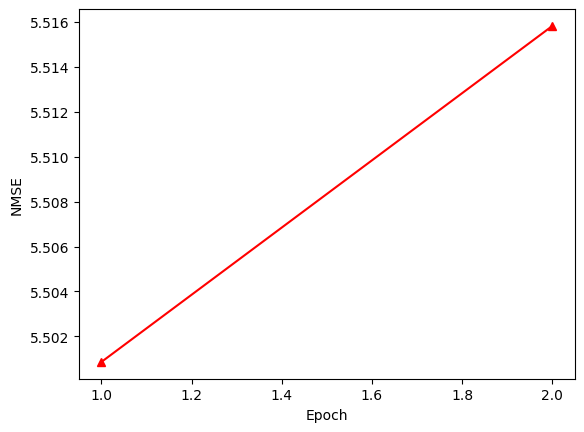

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 14.943209 , Discriminator loss: 0.25665995 , time: 0:06:37.638949
B/E: 103 / 2 , Generator loss: 22.660406 , Discriminator loss: 0.00020023022 , time: 0:06:50.719144
B/E: 206 / 2 , Generator loss: 15.396985 , Discriminator loss: 0.07866149 , time: 0:07:03.818302
B/E: 309 / 2 , Generator loss: 12.138208 , Discriminator loss: 0.17101215 , time: 0:07:16.832256
B/E: 412 / 2 , Generator loss: 19.825485 , Discriminator loss: 0.8282424 , time: 0:07:29.701266
B/E: 515 / 2 , Generator loss: 20.960175 , Discriminator loss: 0.00085036334 , time: 0:07:42.601586
B/E: 618 / 2 , Generator loss: 15.018552 , Discriminator loss: 0.034435235 , time: 0:07:55.773549
B/E: 721 / 2 , Generator loss: 17.171413 , Discriminator loss: 0.001046361 , time: 0:08:08.705411
B/E: 824 / 2 , Generator loss: 15.191605 , Discriminator loss: 0.004653888 , time: 0:08:21.883312
B/E: 927 / 2 , Generator loss: 19.840904 , Discriminator loss: 0.003672207 , time: 0:08:34.802592
B/E: 103

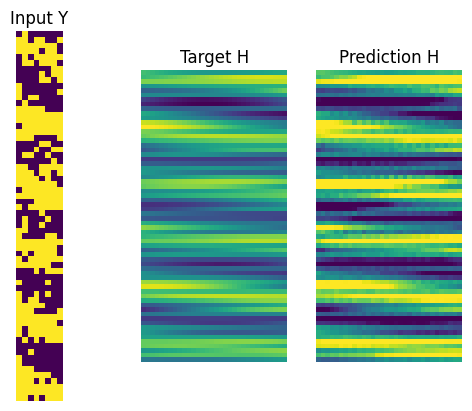

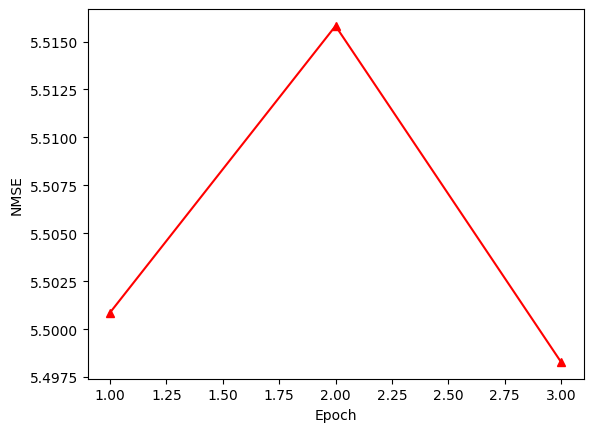

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 15.318159 , Discriminator loss: 0.47481042 , time: 0:09:56.284893
B/E: 103 / 3 , Generator loss: 17.064548 , Discriminator loss: 0.011806865 , time: 0:10:08.952107
B/E: 206 / 3 , Generator loss: 12.507725 , Discriminator loss: 0.8234963 , time: 0:10:22.087749
B/E: 309 / 3 , Generator loss: 20.478699 , Discriminator loss: 0.015346813 , time: 0:10:35.258580
B/E: 412 / 3 , Generator loss: 17.135233 , Discriminator loss: 0.0012158279 , time: 0:10:48.178432
B/E: 515 / 3 , Generator loss: 20.410643 , Discriminator loss: 0.00080261665 , time: 0:11:01.114307
B/E: 618 / 3 , Generator loss: 18.681839 , Discriminator loss: 0.002596991 , time: 0:11:13.887014
B/E: 721 / 3 , Generator loss: 21.118103 , Discriminator loss: 0.042259768 , time: 0:11:26.884824
B/E: 824 / 3 , Generator loss: 15.515848 , Discriminator loss: 0.016901132 , time: 0:11:39.756717
B/E: 927 / 3 , Generator loss: 18.043276 , Discriminator loss: 0.005389127 , time: 0:11:52.678770
B/E: 10

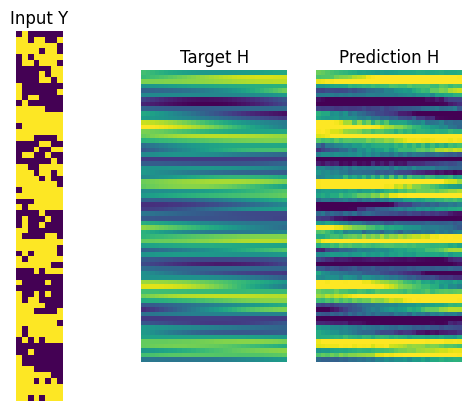

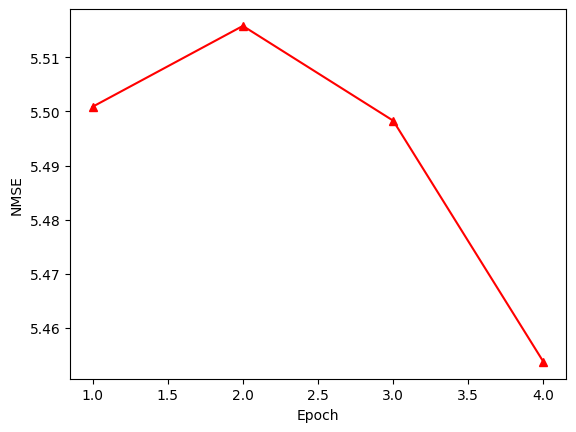

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 18.579191 , Discriminator loss: 0.0020554266 , time: 0:13:12.307421
B/E: 103 / 4 , Generator loss: 20.527782 , Discriminator loss: 0.00034385477 , time: 0:13:25.249829
B/E: 206 / 4 , Generator loss: 17.082308 , Discriminator loss: 0.0064123534 , time: 0:13:39.269503
B/E: 309 / 4 , Generator loss: 16.636826 , Discriminator loss: 0.002688995 , time: 0:13:52.079600
B/E: 412 / 4 , Generator loss: 22.046871 , Discriminator loss: 6.308444e-05 , time: 0:14:04.524408
B/E: 515 / 4 , Generator loss: 22.150898 , Discriminator loss: 0.0002143631 , time: 0:14:17.004843
B/E: 618 / 4 , Generator loss: 17.275599 , Discriminator loss: 0.11209226 , time: 0:14:29.535461
B/E: 721 / 4 , Generator loss: 14.649292 , Discriminator loss: 0.04077083 , time: 0:14:42.424955
B/E: 824 / 4 , Generator loss: 18.755676 , Discriminator loss: 0.0040940177 , time: 0:14:55.495219
B/E: 927 / 4 , Generator loss: 21.168087 , Discriminator loss: 0.0004134293 , time: 0:15:08.392815
B

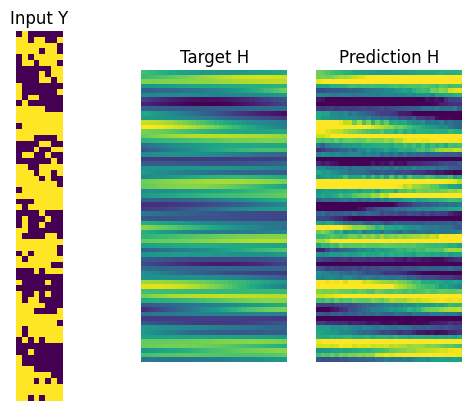

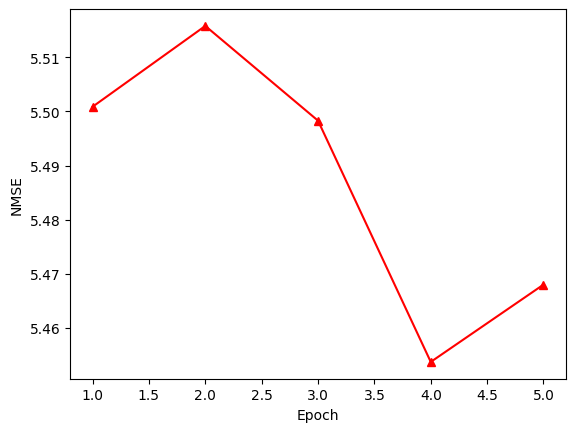

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 17.640556 , Discriminator loss: 0.0056176744 , time: 0:16:28.806064
B/E: 103 / 5 , Generator loss: 15.891485 , Discriminator loss: 0.019687004 , time: 0:16:41.697548
B/E: 206 / 5 , Generator loss: 19.922813 , Discriminator loss: 0.021529684 , time: 0:16:54.768520
B/E: 309 / 5 , Generator loss: 14.112879 , Discriminator loss: 0.13714853 , time: 0:17:07.500656
B/E: 412 / 5 , Generator loss: 20.741383 , Discriminator loss: 0.00014391284 , time: 0:17:20.366967
B/E: 515 / 5 , Generator loss: 19.347025 , Discriminator loss: 0.00053440547 , time: 0:17:33.761596
B/E: 618 / 5 , Generator loss: 14.352081 , Discriminator loss: 0.016094966 , time: 0:17:46.747785
B/E: 721 / 5 , Generator loss: 20.675152 , Discriminator loss: 0.00023173343 , time: 0:17:59.397781
B/E: 824 / 5 , Generator loss: 15.302038 , Discriminator loss: 0.104016915 , time: 0:18:12.258472
B/E: 927 / 5 , Generator loss: 24.857092 , Discriminator loss: 5.1261424e-05 , time: 0:18:25.438067

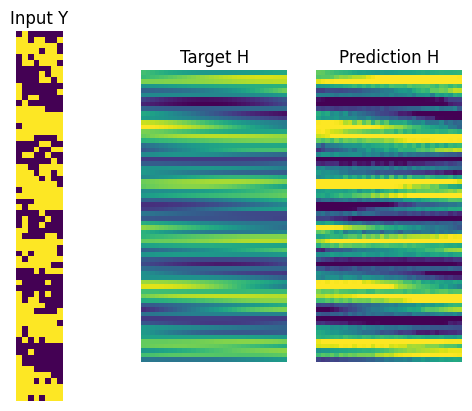

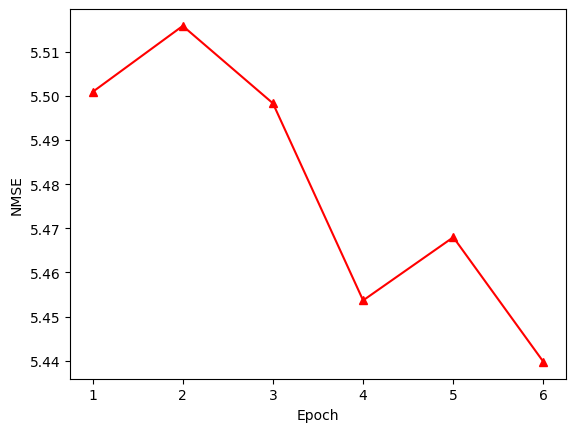

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 18.479694 , Discriminator loss: 0.005666615 , time: 0:19:46.553048
B/E: 103 / 6 , Generator loss: 13.717317 , Discriminator loss: 0.039694488 , time: 0:19:59.442873
B/E: 206 / 6 , Generator loss: 15.66794 , Discriminator loss: 0.006286259 , time: 0:20:12.289307
B/E: 309 / 6 , Generator loss: 17.196753 , Discriminator loss: 0.0037560242 , time: 0:20:25.458751
B/E: 412 / 6 , Generator loss: 13.52477 , Discriminator loss: 0.027329754 , time: 0:20:38.364735
B/E: 515 / 6 , Generator loss: 19.042734 , Discriminator loss: 0.0047507198 , time: 0:20:51.323776
B/E: 618 / 6 , Generator loss: 16.6927 , Discriminator loss: 0.012653767 , time: 0:21:04.389962
B/E: 721 / 6 , Generator loss: 17.692772 , Discriminator loss: 0.009122975 , time: 0:21:17.403700
B/E: 824 / 6 , Generator loss: 17.259106 , Discriminator loss: 0.001780089 , time: 0:21:30.340336
B/E: 927 / 6 , Generator loss: 18.472393 , Discriminator loss: 0.0010276804 , time: 0:21:44.415578
B/E: 103

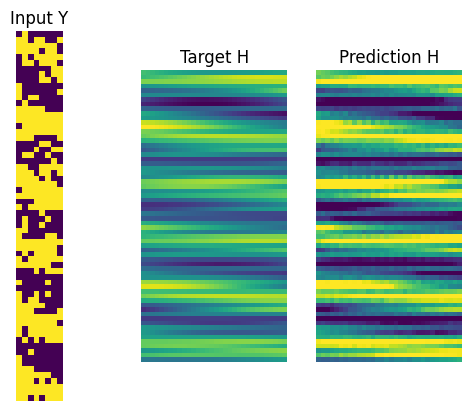

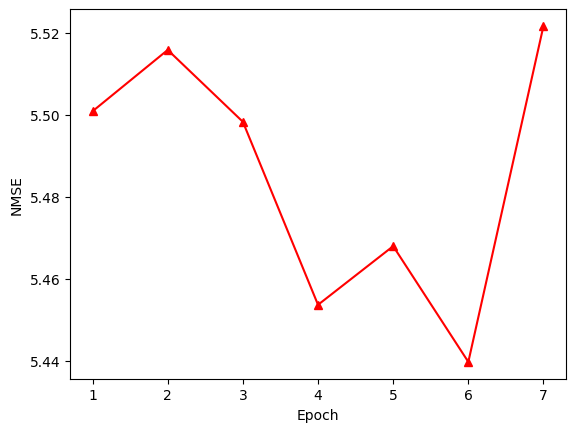

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 18.254902 , Discriminator loss: 0.0033520674 , time: 0:00:00.759835
B/E: 103 / 0 , Generator loss: 20.062325 , Discriminator loss: 0.0005452286 , time: 0:00:13.496649
B/E: 206 / 0 , Generator loss: 18.925915 , Discriminator loss: 0.0024273607 , time: 0:00:26.519475
B/E: 309 / 0 , Generator loss: 11.2250595 , Discriminator loss: 0.972884 , time: 0:00:39.332231
B/E: 412 / 0 , Generator loss: 14.586983 , Discriminator loss: 0.054585613 , time: 0:00:52.302574
B/E: 515 / 0 , Generator loss: 13.186496 , Discriminator loss: 0.07789808 , time: 0:01:05.165729
B/E: 618 / 0 , Generator loss: 17.37071 , Discriminator loss: 0.0063539227 , time: 0:01:18.313652
B/E: 721 / 0 , Generator loss: 18.44989 , Discriminator loss: 0.00047030038 , time: 0:01:31.272638
B/E: 824 / 0 , Generator loss: 24.326557 , Discriminator loss: 2.4202123e-05 , time: 0:01:44.185296
B/E: 927 / 0 , Generator loss: 19.313023 , Discriminator loss: 0.001899608 , time: 0:01:57.216296
B/E:

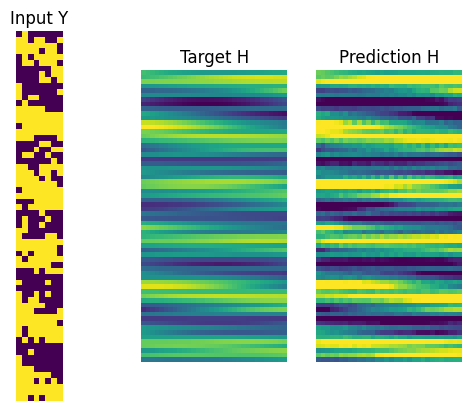

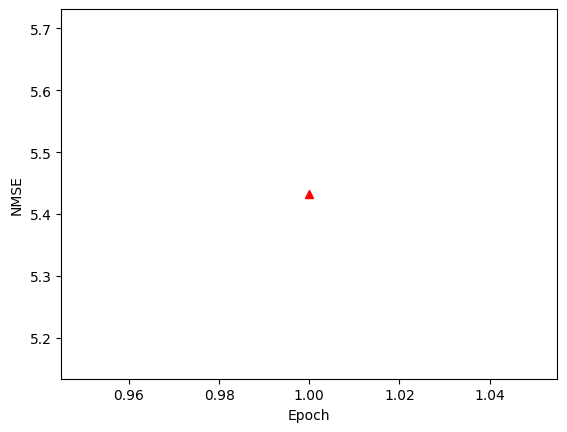

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 22.700062 , Discriminator loss: 5.4136814e-05 , time: 0:03:18.911315
B/E: 103 / 1 , Generator loss: 18.712025 , Discriminator loss: 0.023276193 , time: 0:03:31.605779
B/E: 206 / 1 , Generator loss: 16.996717 , Discriminator loss: 0.009494435 , time: 0:03:44.315075
B/E: 309 / 1 , Generator loss: 18.333435 , Discriminator loss: 0.00046246144 , time: 0:03:57.094674
B/E: 412 / 1 , Generator loss: 17.626686 , Discriminator loss: 0.0028149367 , time: 0:04:10.001390
B/E: 515 / 1 , Generator loss: 17.539717 , Discriminator loss: 0.011816597 , time: 0:04:22.978687
B/E: 618 / 1 , Generator loss: 21.299892 , Discriminator loss: 0.00050733966 , time: 0:04:35.961055
B/E: 721 / 1 , Generator loss: 17.563934 , Discriminator loss: 0.0019790037 , time: 0:04:48.819306
B/E: 824 / 1 , Generator loss: 14.398937 , Discriminator loss: 0.04798195 , time: 0:05:01.762026
B/E: 927 / 1 , Generator loss: 19.838882 , Discriminator loss: 0.007975088 , time: 0:05:14.718779


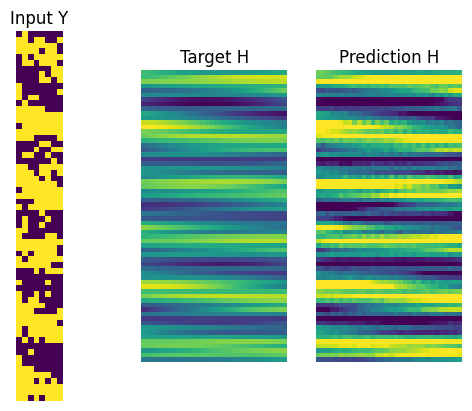

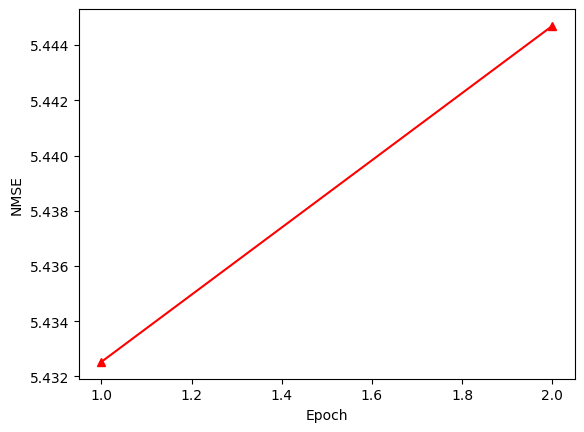

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 19.033329 , Discriminator loss: 0.0013372367 , time: 0:06:35.630877
B/E: 103 / 2 , Generator loss: 24.458878 , Discriminator loss: 3.1837318 , time: 0:06:50.454123
B/E: 206 / 2 , Generator loss: 22.729145 , Discriminator loss: 0.013516235 , time: 0:07:03.522648
B/E: 309 / 2 , Generator loss: 19.901623 , Discriminator loss: 0.00036389605 , time: 0:07:16.454165
B/E: 412 / 2 , Generator loss: 17.89299 , Discriminator loss: 0.0045239558 , time: 0:07:29.217180
B/E: 515 / 2 , Generator loss: 17.381588 , Discriminator loss: 0.006708585 , time: 0:07:41.807834
B/E: 618 / 2 , Generator loss: 19.708992 , Discriminator loss: 0.0003814101 , time: 0:07:54.541916
B/E: 721 / 2 , Generator loss: 20.225409 , Discriminator loss: 0.00031683172 , time: 0:08:07.526124
B/E: 824 / 2 , Generator loss: 16.6441 , Discriminator loss: 0.006555332 , time: 0:08:20.554865
B/E: 927 / 2 , Generator loss: 19.089926 , Discriminator loss: 0.00037226468 , time: 0:08:33.527387
B/E

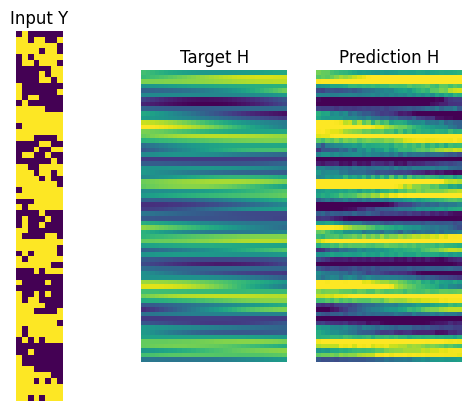

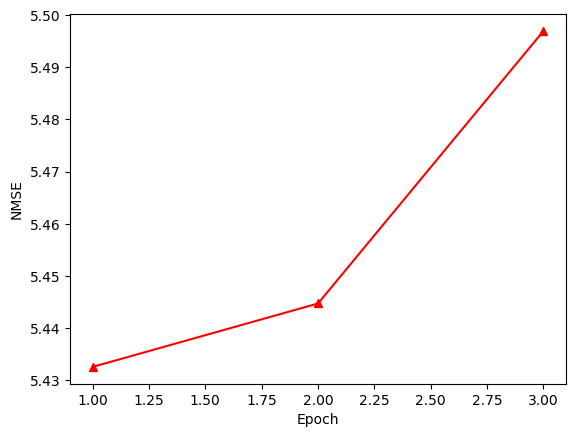

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 21.636086 , Discriminator loss: 8.6310596e-05 , time: 0:09:53.848704
B/E: 103 / 3 , Generator loss: 13.52645 , Discriminator loss: 0.12356518 , time: 0:10:06.982309
B/E: 206 / 3 , Generator loss: 20.435112 , Discriminator loss: 0.0009562596 , time: 0:10:19.925500
B/E: 309 / 3 , Generator loss: 23.710224 , Discriminator loss: 0.027327033 , time: 0:10:32.837776
B/E: 412 / 3 , Generator loss: 18.534014 , Discriminator loss: 0.00026432794 , time: 0:10:45.747162
B/E: 515 / 3 , Generator loss: 17.592892 , Discriminator loss: 0.0037577352 , time: 0:11:00.180081
B/E: 618 / 3 , Generator loss: 20.576 , Discriminator loss: 0.0013402378 , time: 0:11:13.444646
B/E: 721 / 3 , Generator loss: 19.973915 , Discriminator loss: 0.0002774166 , time: 0:11:26.415504
B/E: 824 / 3 , Generator loss: 21.392384 , Discriminator loss: 0.00020466706 , time: 0:11:38.956822
B/E: 927 / 3 , Generator loss: 14.888636 , Discriminator loss: 0.0266072 , time: 0:11:51.773991
B/E:

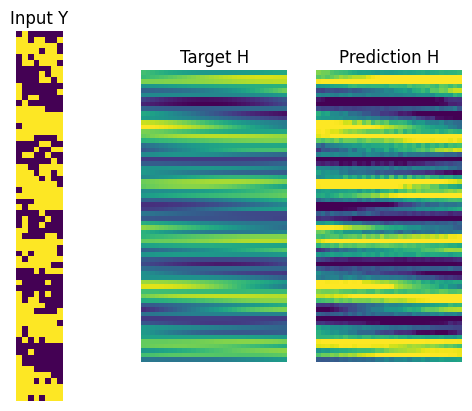

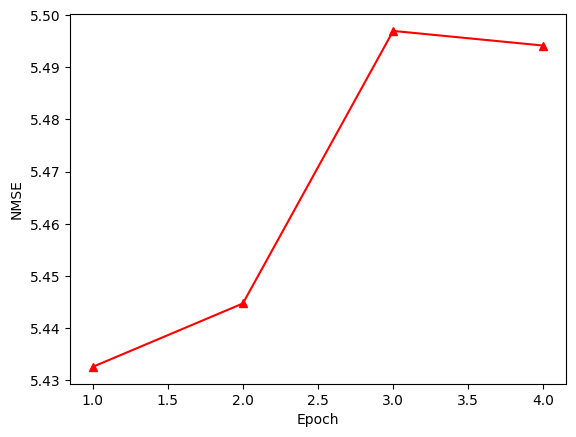

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 20.012499 , Discriminator loss: 0.00046550532 , time: 0:13:14.704096
B/E: 103 / 4 , Generator loss: 17.512737 , Discriminator loss: 0.012699374 , time: 0:13:27.755783
B/E: 206 / 4 , Generator loss: 24.816576 , Discriminator loss: 0.003787046 , time: 0:13:40.851521
B/E: 309 / 4 , Generator loss: 16.061777 , Discriminator loss: 0.010944839 , time: 0:13:53.911771
B/E: 412 / 4 , Generator loss: 20.993143 , Discriminator loss: 0.00021173588 , time: 0:14:07.056233
B/E: 515 / 4 , Generator loss: 13.843151 , Discriminator loss: 0.019951334 , time: 0:14:20.110624
B/E: 618 / 4 , Generator loss: 18.183163 , Discriminator loss: 0.002956737 , time: 0:14:33.076826
B/E: 721 / 4 , Generator loss: 18.643944 , Discriminator loss: 0.0041885013 , time: 0:14:46.173701
B/E: 824 / 4 , Generator loss: 20.35248 , Discriminator loss: 0.00022541195 , time: 0:14:59.249216
B/E: 927 / 4 , Generator loss: 21.651356 , Discriminator loss: 0.000177962 , time: 0:15:13.708470
B

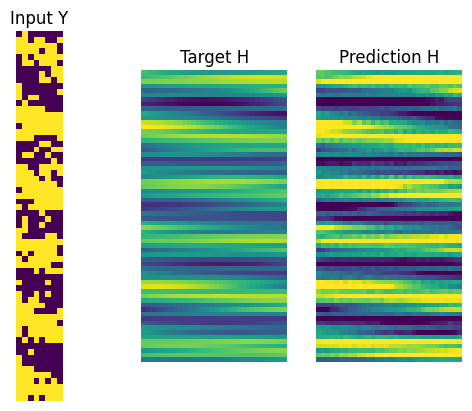

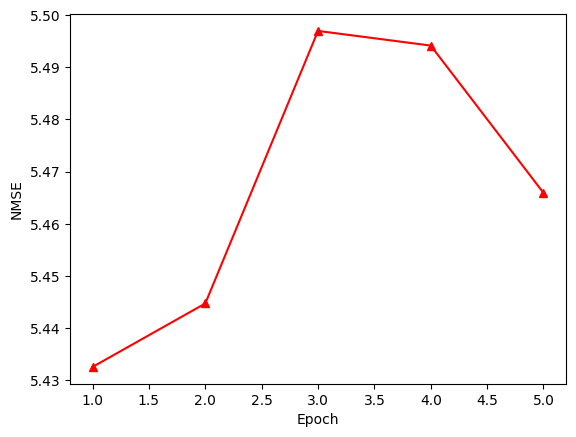

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 20.382395 , Discriminator loss: 0.002185368 , time: 0:16:35.990868
B/E: 103 / 5 , Generator loss: 18.412521 , Discriminator loss: 0.0004344096 , time: 0:16:49.292162
B/E: 206 / 5 , Generator loss: 16.489677 , Discriminator loss: 0.0038869386 , time: 0:17:02.663083
B/E: 309 / 5 , Generator loss: 25.13496 , Discriminator loss: 0.0016616218 , time: 0:17:16.097553
B/E: 412 / 5 , Generator loss: 16.717627 , Discriminator loss: 0.011908442 , time: 0:17:29.474039
B/E: 515 / 5 , Generator loss: 18.376945 , Discriminator loss: 0.011339676 , time: 0:17:42.708809
B/E: 618 / 5 , Generator loss: 15.846096 , Discriminator loss: 0.006263562 , time: 0:17:55.869289
B/E: 721 / 5 , Generator loss: 14.645687 , Discriminator loss: 0.012831389 , time: 0:18:08.812752
B/E: 824 / 5 , Generator loss: 16.226398 , Discriminator loss: 0.010295641 , time: 0:18:21.835128
B/E: 927 / 5 , Generator loss: 18.484024 , Discriminator loss: 0.009948881 , time: 0:18:34.901592
B/E: 

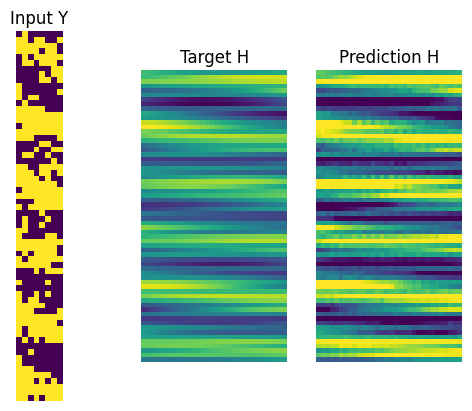

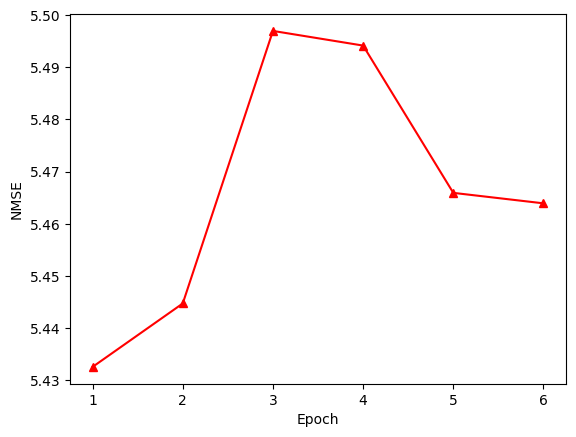

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 19.787182 , Discriminator loss: 0.003106569 , time: 0:19:58.339197
B/E: 103 / 6 , Generator loss: 15.131939 , Discriminator loss: 0.01937984 , time: 0:20:11.731959
B/E: 206 / 6 , Generator loss: 19.177452 , Discriminator loss: 0.006375939 , time: 0:20:24.992681
B/E: 309 / 6 , Generator loss: 18.369808 , Discriminator loss: 0.0013181887 , time: 0:20:38.203515
B/E: 412 / 6 , Generator loss: 18.274992 , Discriminator loss: 0.0017859648 , time: 0:20:51.413433
B/E: 515 / 6 , Generator loss: 21.01139 , Discriminator loss: 0.013735697 , time: 0:21:04.735927
B/E: 618 / 6 , Generator loss: 21.512283 , Discriminator loss: 0.00012208983 , time: 0:21:18.156139
B/E: 721 / 6 , Generator loss: 21.44853 , Discriminator loss: 0.00058093737 , time: 0:21:31.391037
B/E: 824 / 6 , Generator loss: 22.473816 , Discriminator loss: 0.00013162332 , time: 0:21:44.745578
B/E: 927 / 6 , Generator loss: 21.885197 , Discriminator loss: 0.00019901454 , time: 0:21:57.943610


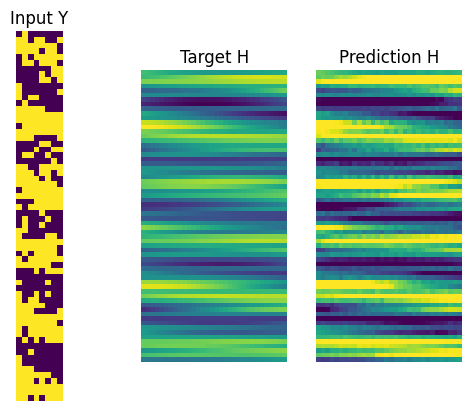

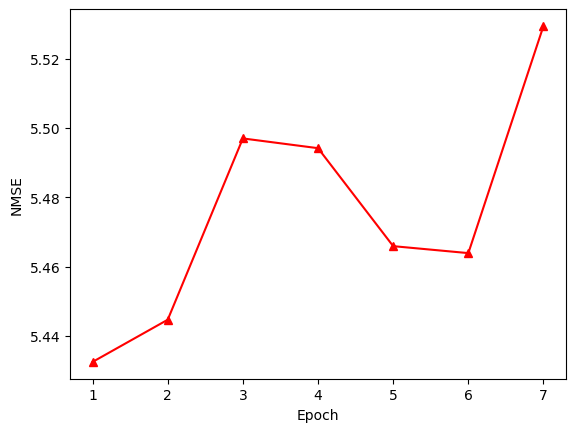

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 21.065395 , Discriminator loss: 0.00023189977 , time: 0:00:00.585865
B/E: 103 / 0 , Generator loss: 23.20274 , Discriminator loss: 4.4086795e-05 , time: 0:00:15.238392
B/E: 206 / 0 , Generator loss: 22.057232 , Discriminator loss: 6.269261e-05 , time: 0:00:28.486357
B/E: 309 / 0 , Generator loss: 17.054651 , Discriminator loss: 0.001557606 , time: 0:00:41.560047
B/E: 412 / 0 , Generator loss: 16.838717 , Discriminator loss: 0.031109506 , time: 0:00:54.629710
B/E: 515 / 0 , Generator loss: 14.033828 , Discriminator loss: 0.038051654 , time: 0:01:07.698991
B/E: 618 / 0 , Generator loss: 13.5248575 , Discriminator loss: 0.14504257 , time: 0:01:20.700727
B/E: 721 / 0 , Generator loss: 15.187768 , Discriminator loss: 0.005681981 , time: 0:01:33.588632
B/E: 824 / 0 , Generator loss: 15.255501 , Discriminator loss: 0.01639642 , time: 0:01:46.115442
B/E: 927 / 0 , Generator loss: 22.521618 , Discriminator loss: 0.01163244 , time: 0:01:59.032093
B/E: 

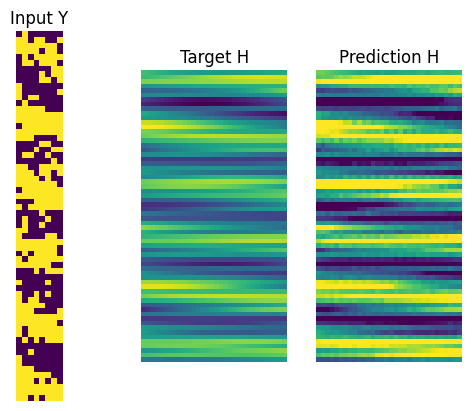

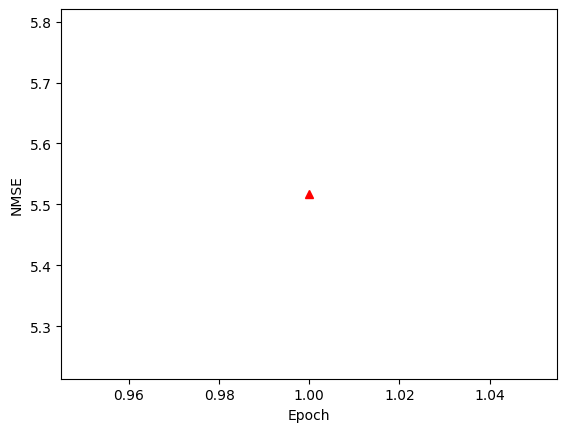

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 21.988441 , Discriminator loss: 0.00010530568 , time: 0:03:19.672214
B/E: 103 / 1 , Generator loss: 15.3189125 , Discriminator loss: 0.020695413 , time: 0:03:32.724186
B/E: 206 / 1 , Generator loss: 14.791413 , Discriminator loss: 0.02345889 , time: 0:03:45.798065
B/E: 309 / 1 , Generator loss: 27.379639 , Discriminator loss: 7.96952e-05 , time: 0:03:58.856011
B/E: 412 / 1 , Generator loss: 21.137772 , Discriminator loss: 0.0015825374 , time: 0:04:11.885910
B/E: 515 / 1 , Generator loss: 21.802776 , Discriminator loss: 0.0055059604 , time: 0:04:24.982971
B/E: 618 / 1 , Generator loss: 17.399788 , Discriminator loss: 0.00625517 , time: 0:04:39.520187
B/E: 721 / 1 , Generator loss: 24.805344 , Discriminator loss: 8.1880404e-05 , time: 0:04:52.702429
B/E: 824 / 1 , Generator loss: 20.027065 , Discriminator loss: 0.00082686776 , time: 0:05:05.870270
B/E: 927 / 1 , Generator loss: 22.23169 , Discriminator loss: 0.020092968 , time: 0:05:18.801969
B

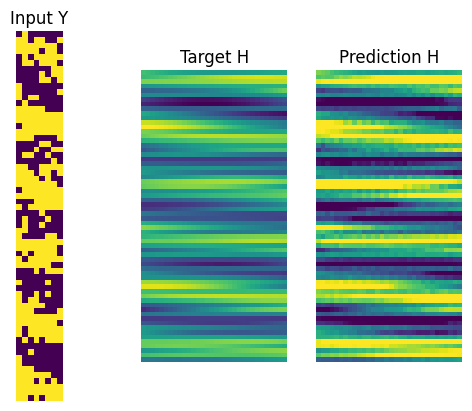

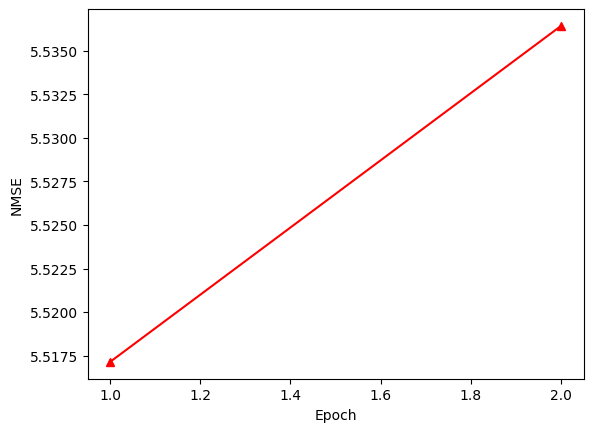

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 27.961784 , Discriminator loss: 0.0010533023 , time: 0:06:40.056134
B/E: 103 / 2 , Generator loss: 21.78771 , Discriminator loss: 0.00033856073 , time: 0:06:52.760933
B/E: 206 / 2 , Generator loss: 19.216673 , Discriminator loss: 0.03994952 , time: 0:07:05.776726
B/E: 309 / 2 , Generator loss: 23.262112 , Discriminator loss: 2.7220063e-05 , time: 0:07:18.498580
B/E: 412 / 2 , Generator loss: 20.512836 , Discriminator loss: 0.00022116187 , time: 0:07:31.417221
B/E: 515 / 2 , Generator loss: 20.01079 , Discriminator loss: 0.0006674048 , time: 0:07:44.407067
B/E: 618 / 2 , Generator loss: 19.594406 , Discriminator loss: 0.026184216 , time: 0:07:57.493107
B/E: 721 / 2 , Generator loss: 20.78083 , Discriminator loss: 0.0013411266 , time: 0:08:10.746785
B/E: 824 / 2 , Generator loss: 20.825706 , Discriminator loss: 0.0008278432 , time: 0:08:23.863488
B/E: 927 / 2 , Generator loss: 20.583637 , Discriminator loss: 0.00018307922 , time: 0:08:36.867628

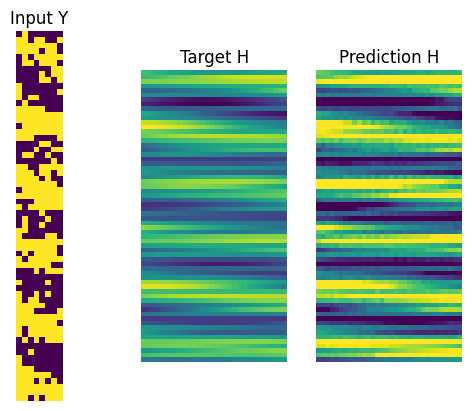

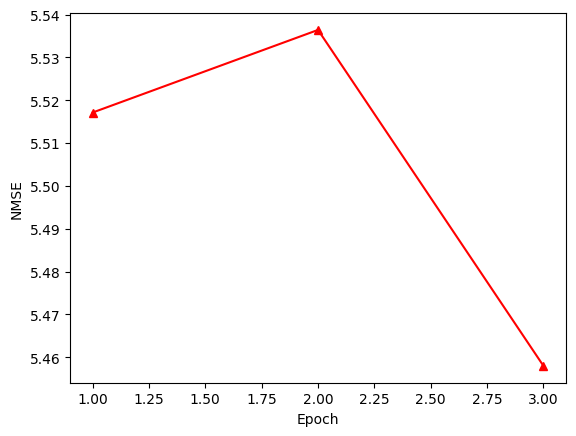

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 18.402641 , Discriminator loss: 0.00028195634 , time: 0:09:58.850003
B/E: 103 / 3 , Generator loss: 24.077858 , Discriminator loss: 7.775009e-05 , time: 0:10:12.420817
B/E: 206 / 3 , Generator loss: 19.753757 , Discriminator loss: 0.00060958986 , time: 0:10:25.747324
B/E: 309 / 3 , Generator loss: 16.452917 , Discriminator loss: 0.008187582 , time: 0:10:39.195972
B/E: 412 / 3 , Generator loss: 20.263489 , Discriminator loss: 0.00014594 , time: 0:10:52.282864
B/E: 515 / 3 , Generator loss: 15.4937525 , Discriminator loss: 0.006318563 , time: 0:11:05.478031
B/E: 618 / 3 , Generator loss: 18.357372 , Discriminator loss: 0.0022342575 , time: 0:11:18.407554
B/E: 721 / 3 , Generator loss: 21.022152 , Discriminator loss: 0.00077101303 , time: 0:11:31.117570
B/E: 824 / 3 , Generator loss: 19.418247 , Discriminator loss: 0.016155427 , time: 0:11:43.936994
B/E: 927 / 3 , Generator loss: 20.074263 , Discriminator loss: 0.00020586609 , time: 0:11:57.2880

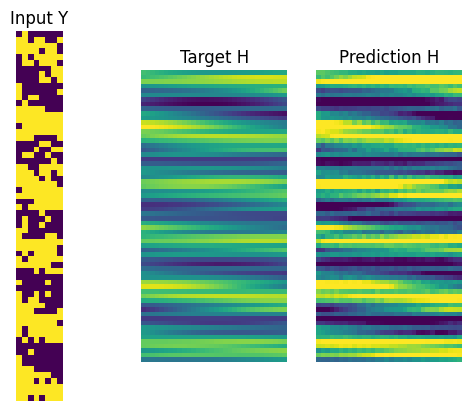

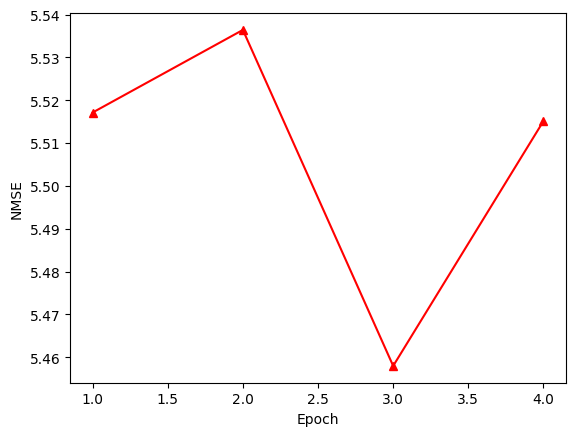

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 22.33031 , Discriminator loss: 0.0011830238 , time: 0:13:20.471627
B/E: 103 / 4 , Generator loss: 16.948595 , Discriminator loss: 0.0045132623 , time: 0:13:33.370550
B/E: 206 / 4 , Generator loss: 19.970394 , Discriminator loss: 0.004788772 , time: 0:13:46.259832
B/E: 309 / 4 , Generator loss: 25.584545 , Discriminator loss: 0.0034080287 , time: 0:13:59.280963
B/E: 412 / 4 , Generator loss: 16.308884 , Discriminator loss: 0.039379925 , time: 0:14:12.412752
B/E: 515 / 4 , Generator loss: 26.840336 , Discriminator loss: 0.00022926058 , time: 0:14:25.420304
B/E: 618 / 4 , Generator loss: 20.424294 , Discriminator loss: 6.868478e-05 , time: 0:14:38.541910
B/E: 721 / 4 , Generator loss: 18.94287 , Discriminator loss: 0.0004355159 , time: 0:14:51.325564
B/E: 824 / 4 , Generator loss: 16.039988 , Discriminator loss: 0.014271842 , time: 0:15:04.427536
B/E: 927 / 4 , Generator loss: 19.754803 , Discriminator loss: 0.00077699625 , time: 0:15:17.477147


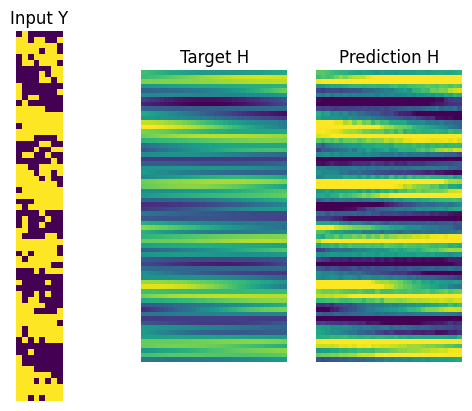

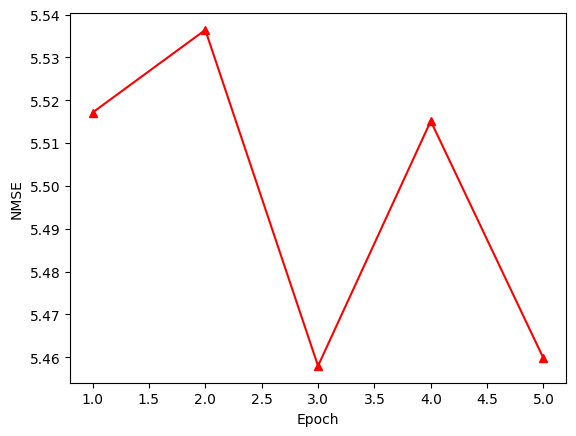

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 17.325127 , Discriminator loss: 0.0006066016 , time: 0:16:38.528794
B/E: 103 / 5 , Generator loss: 17.058985 , Discriminator loss: 0.011415346 , time: 0:16:51.638127
B/E: 206 / 5 , Generator loss: 25.402515 , Discriminator loss: 1.4604077e-05 , time: 0:17:04.706870
B/E: 309 / 5 , Generator loss: 23.441753 , Discriminator loss: 6.8548056e-06 , time: 0:17:17.531786
B/E: 412 / 5 , Generator loss: 18.204868 , Discriminator loss: 0.00085267855 , time: 0:17:30.178180
B/E: 515 / 5 , Generator loss: 19.870201 , Discriminator loss: 0.0012678435 , time: 0:17:45.231098
B/E: 618 / 5 , Generator loss: 16.99146 , Discriminator loss: 0.0025794785 , time: 0:17:57.816092
B/E: 721 / 5 , Generator loss: 20.960451 , Discriminator loss: 4.9010025e-05 , time: 0:18:10.871798
B/E: 824 / 5 , Generator loss: 20.499027 , Discriminator loss: 0.0047577857 , time: 0:18:23.465019
B/E: 927 / 5 , Generator loss: 18.372128 , Discriminator loss: 0.001086722 , time: 0:18:36.553

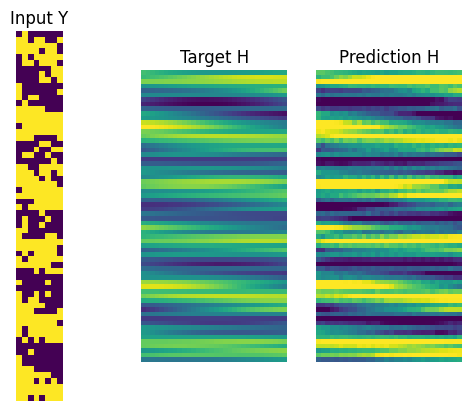

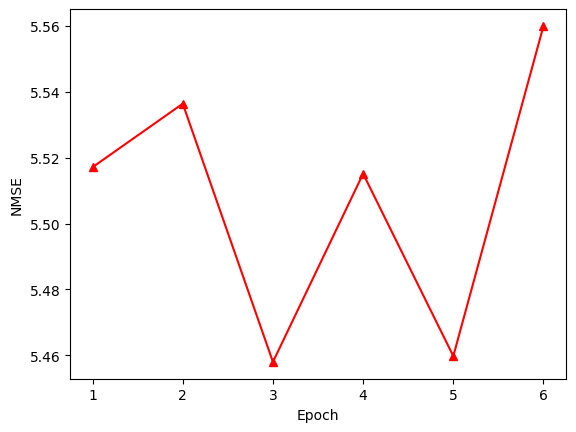

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 25.778036 , Discriminator loss: 9.977959e-06 , time: 0:19:57.652932
B/E: 103 / 6 , Generator loss: 18.91488 , Discriminator loss: 0.0006262613 , time: 0:20:10.849290
B/E: 206 / 6 , Generator loss: 21.203075 , Discriminator loss: 0.0008611852 , time: 0:20:23.739936
B/E: 309 / 6 , Generator loss: 21.4081 , Discriminator loss: 0.0008492419 , time: 0:20:36.798015
B/E: 412 / 6 , Generator loss: 26.32676 , Discriminator loss: 3.372812e-05 , time: 0:20:49.957554
B/E: 515 / 6 , Generator loss: 21.811487 , Discriminator loss: 0.00079398474 , time: 0:21:03.156869
B/E: 618 / 6 , Generator loss: 21.100676 , Discriminator loss: 0.00023207715 , time: 0:21:16.436882
B/E: 721 / 6 , Generator loss: 19.534939 , Discriminator loss: 0.00052957324 , time: 0:21:29.377657
B/E: 824 / 6 , Generator loss: 16.221863 , Discriminator loss: 0.0053528217 , time: 0:21:42.605243
B/E: 927 / 6 , Generator loss: 22.14899 , Discriminator loss: 3.871951e-05 , time: 0:21:55.635817

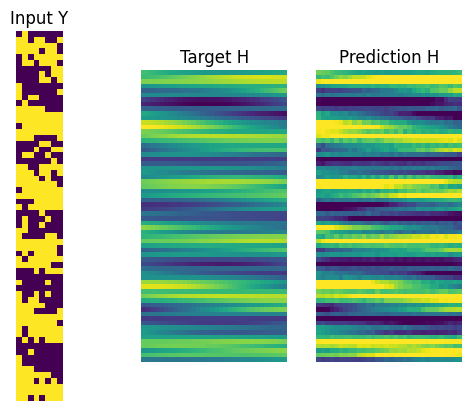

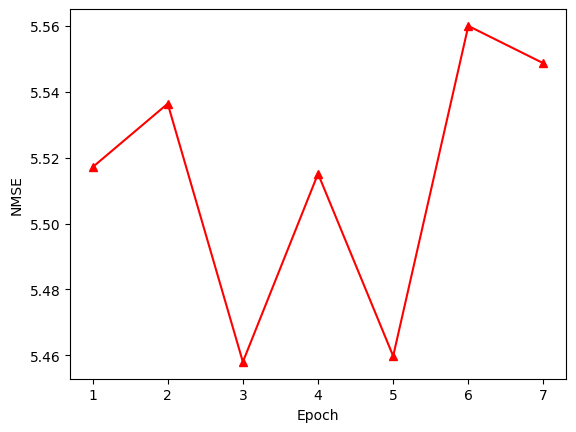

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 19.280407 , Discriminator loss: 0.003234265 , time: 0:00:00.762057
B/E: 103 / 0 , Generator loss: 17.264671 , Discriminator loss: 0.003409503 , time: 0:00:14.017668
B/E: 206 / 0 , Generator loss: 16.24617 , Discriminator loss: 0.0017421365 , time: 0:00:27.310772
B/E: 309 / 0 , Generator loss: 23.565887 , Discriminator loss: 1.6231395e-05 , time: 0:00:40.606142
B/E: 412 / 0 , Generator loss: 13.934934 , Discriminator loss: 0.09307905 , time: 0:00:54.120607
B/E: 515 / 0 , Generator loss: 23.61227 , Discriminator loss: 1.9481568e-05 , time: 0:01:07.565856
B/E: 618 / 0 , Generator loss: 25.141186 , Discriminator loss: 0.010710885 , time: 0:01:20.964533
B/E: 721 / 0 , Generator loss: 23.936977 , Discriminator loss: 4.6484016e-05 , time: 0:01:34.325981
B/E: 824 / 0 , Generator loss: 21.40811 , Discriminator loss: 7.1590126e-05 , time: 0:01:47.591220
B/E: 927 / 0 , Generator loss: 19.988125 , Discriminator loss: 0.004656307 , time: 0:02:00.739563
B/

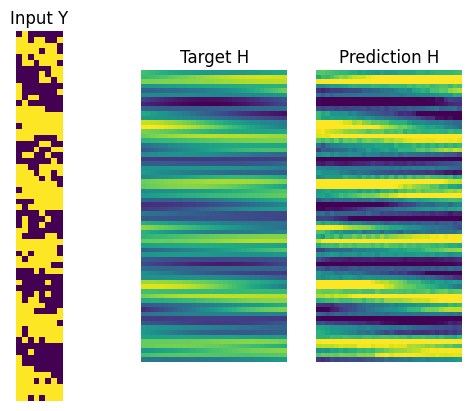

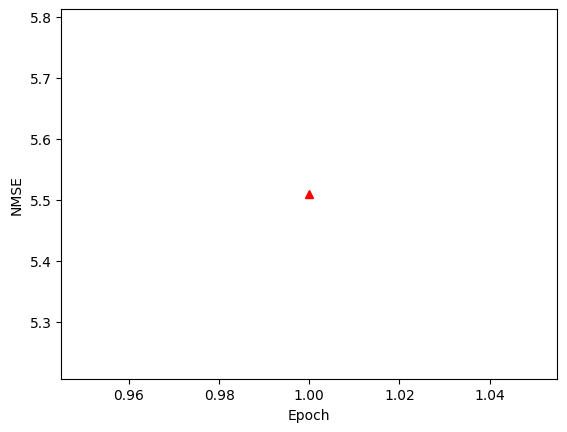

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 24.12197 , Discriminator loss: 9.955809e-06 , time: 0:03:23.500858
B/E: 103 / 1 , Generator loss: 16.845741 , Discriminator loss: 0.0009221341 , time: 0:03:36.761531
B/E: 206 / 1 , Generator loss: 15.945009 , Discriminator loss: 0.005874912 , time: 0:03:50.130158
B/E: 309 / 1 , Generator loss: 19.060368 , Discriminator loss: 0.00032211203 , time: 0:04:03.274365
B/E: 412 / 1 , Generator loss: 18.638992 , Discriminator loss: 0.004866385 , time: 0:04:16.147720
B/E: 515 / 1 , Generator loss: 22.375465 , Discriminator loss: 3.9070233e-05 , time: 0:04:29.011928
B/E: 618 / 1 , Generator loss: 24.086441 , Discriminator loss: 0.009193295 , time: 0:04:41.984792
B/E: 721 / 1 , Generator loss: 20.634281 , Discriminator loss: 0.00021391179 , time: 0:04:55.045058
B/E: 824 / 1 , Generator loss: 18.001797 , Discriminator loss: 0.0010540899 , time: 0:05:07.741804
B/E: 927 / 1 , Generator loss: 21.724133 , Discriminator loss: 0.00021346596 , time: 0:05:20.1063

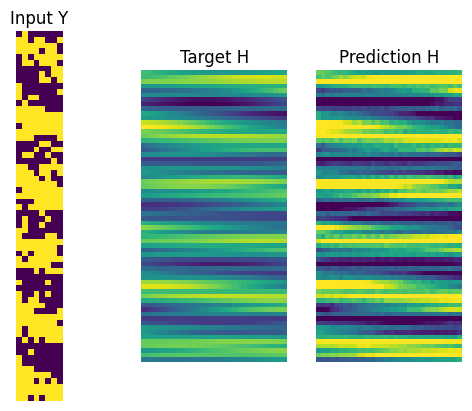

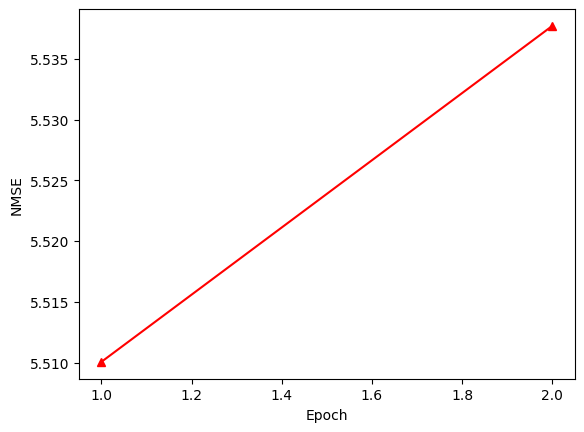

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 23.22609 , Discriminator loss: 2.6854023e-05 , time: 0:06:40.301240
B/E: 103 / 2 , Generator loss: 16.535254 , Discriminator loss: 0.03244588 , time: 0:06:53.302489
B/E: 206 / 2 , Generator loss: 21.54684 , Discriminator loss: 7.789139e-05 , time: 0:07:06.410870
B/E: 309 / 2 , Generator loss: 21.589306 , Discriminator loss: 0.00011060106 , time: 0:07:19.312131
B/E: 412 / 2 , Generator loss: 17.2951 , Discriminator loss: 0.002297835 , time: 0:07:32.309967
B/E: 515 / 2 , Generator loss: 23.784744 , Discriminator loss: 2.7327673e-05 , time: 0:07:46.907284
B/E: 618 / 2 , Generator loss: 21.279808 , Discriminator loss: 0.0010367054 , time: 0:08:00.005961
B/E: 721 / 2 , Generator loss: 20.063774 , Discriminator loss: 0.00354743 , time: 0:08:12.941018
B/E: 824 / 2 , Generator loss: 19.006004 , Discriminator loss: 0.34858227 , time: 0:08:25.979990
B/E: 927 / 2 , Generator loss: 19.897339 , Discriminator loss: 0.00010788577 , time: 0:08:39.057747
B/E:

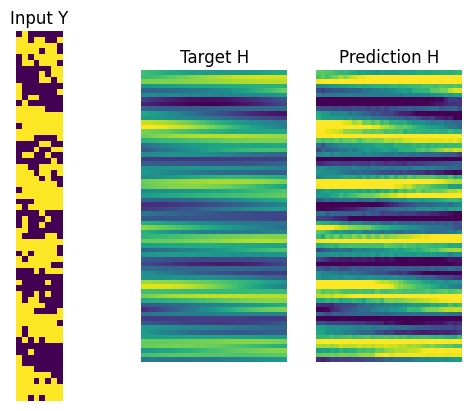

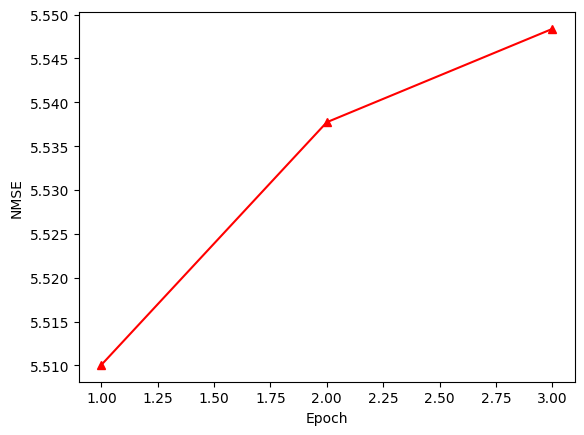

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 21.106598 , Discriminator loss: 0.00044384977 , time: 0:10:01.262332
B/E: 103 / 3 , Generator loss: 22.789291 , Discriminator loss: 5.8094312e-05 , time: 0:10:14.908327
B/E: 206 / 3 , Generator loss: 17.61411 , Discriminator loss: 0.004061286 , time: 0:10:28.470463
B/E: 309 / 3 , Generator loss: 26.717937 , Discriminator loss: 3.6284912e-06 , time: 0:10:42.219633
B/E: 412 / 3 , Generator loss: 19.867294 , Discriminator loss: 0.00081500877 , time: 0:10:55.644887
B/E: 515 / 3 , Generator loss: 26.352123 , Discriminator loss: 4.1127855e-06 , time: 0:11:09.047228
B/E: 618 / 3 , Generator loss: 17.930784 , Discriminator loss: 0.0017998113 , time: 0:11:22.375378
B/E: 721 / 3 , Generator loss: 21.947363 , Discriminator loss: 0.00064582645 , time: 0:11:35.658800
B/E: 824 / 3 , Generator loss: 24.592926 , Discriminator loss: 0.0002528957 , time: 0:11:48.976484
B/E: 927 / 3 , Generator loss: 15.182478 , Discriminator loss: 0.020531012 , time: 0:12:02.2

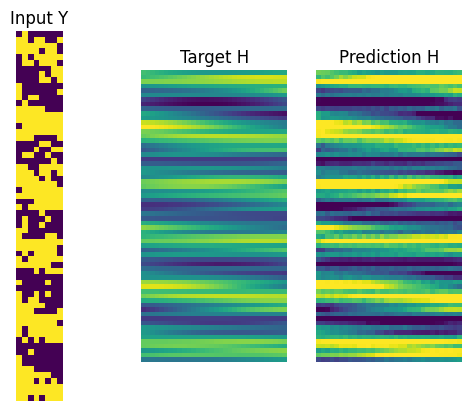

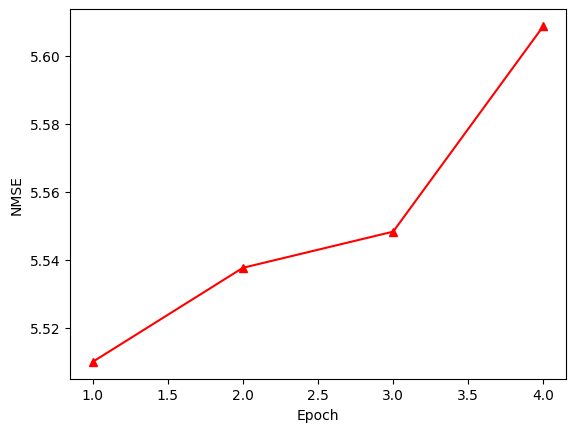

-----
EPOCH: 4
B/E: 0 / 4 , Generator loss: 19.196655 , Discriminator loss: 0.0035910383 , time: 0:13:28.193760
B/E: 103 / 4 , Generator loss: 19.514557 , Discriminator loss: 0.0021034486 , time: 0:13:41.617476
B/E: 206 / 4 , Generator loss: 20.973976 , Discriminator loss: 6.350386e-05 , time: 0:13:54.548002
B/E: 309 / 4 , Generator loss: 23.728794 , Discriminator loss: 2.4227616e-05 , time: 0:14:07.718077
B/E: 412 / 4 , Generator loss: 23.027794 , Discriminator loss: 0.00022872677 , time: 0:14:20.960636
B/E: 515 / 4 , Generator loss: 23.59593 , Discriminator loss: 5.9184997e-05 , time: 0:14:34.104319
B/E: 618 / 4 , Generator loss: 18.178612 , Discriminator loss: 0.0007152694 , time: 0:14:47.127036
B/E: 721 / 4 , Generator loss: 19.274006 , Discriminator loss: 0.0009526911 , time: 0:15:00.231982
B/E: 824 / 4 , Generator loss: 23.47062 , Discriminator loss: 0.0019102896 , time: 0:15:13.466892
B/E: 927 / 4 , Generator loss: 20.96629 , Discriminator loss: 0.0008750896 , time: 0:15:26.7969

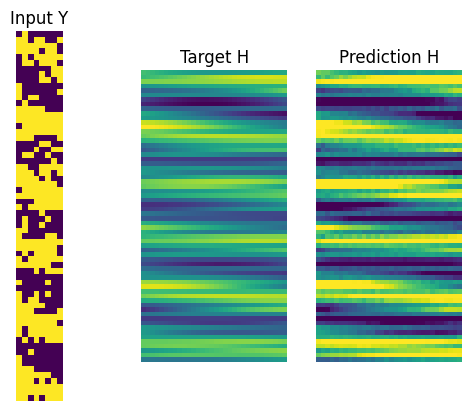

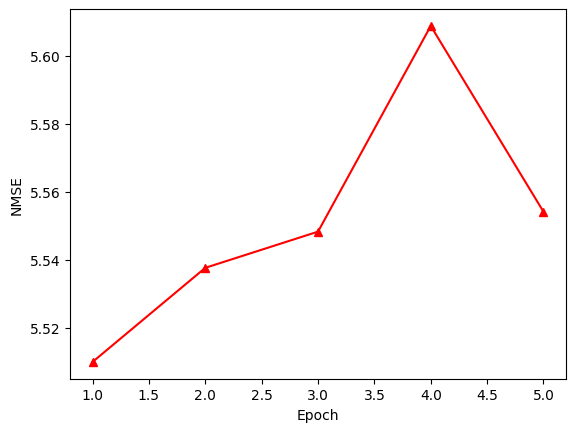

-----
EPOCH: 5
B/E: 0 / 5 , Generator loss: 22.909113 , Discriminator loss: 3.635013e-05 , time: 0:16:50.290806
B/E: 103 / 5 , Generator loss: 28.685251 , Discriminator loss: 5.4693476e-07 , time: 0:17:03.796286
B/E: 206 / 5 , Generator loss: 21.972084 , Discriminator loss: 0.0031538445 , time: 0:17:17.212100
B/E: 309 / 5 , Generator loss: 18.857145 , Discriminator loss: 0.0015970285 , time: 0:17:30.647526
B/E: 412 / 5 , Generator loss: 24.699207 , Discriminator loss: 0.00010023075 , time: 0:17:44.208626
B/E: 515 / 5 , Generator loss: 24.902363 , Discriminator loss: 4.7395824e-05 , time: 0:17:57.941219
B/E: 618 / 5 , Generator loss: 22.15123 , Discriminator loss: 8.574286e-05 , time: 0:18:11.550559
B/E: 721 / 5 , Generator loss: 23.826801 , Discriminator loss: 3.3511773e-05 , time: 0:18:25.217376
B/E: 824 / 5 , Generator loss: 23.865791 , Discriminator loss: 4.387785e-05 , time: 0:18:38.668021
B/E: 927 / 5 , Generator loss: 21.586353 , Discriminator loss: 1.7127191e-05 , time: 0:18:51.

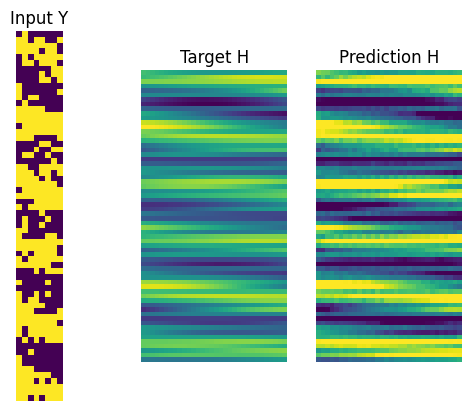

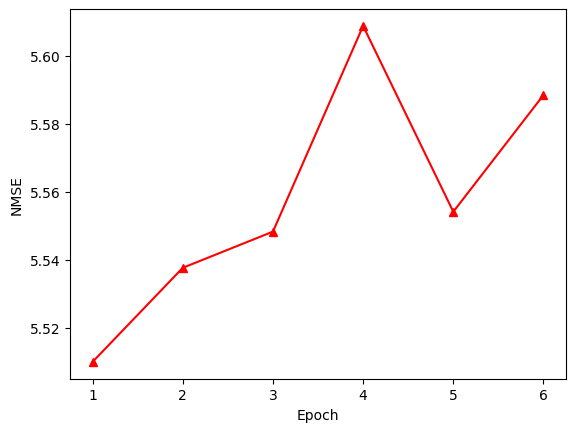

-----
EPOCH: 6
B/E: 0 / 6 , Generator loss: 21.508179 , Discriminator loss: 3.388068e-05 , time: 0:20:16.430144
B/E: 103 / 6 , Generator loss: 17.278328 , Discriminator loss: 0.0054922723 , time: 0:20:30.445554
B/E: 206 / 6 , Generator loss: 15.801567 , Discriminator loss: 0.003955272 , time: 0:20:44.546710
B/E: 309 / 6 , Generator loss: 19.678864 , Discriminator loss: 0.00027546732 , time: 0:20:58.332523
B/E: 412 / 6 , Generator loss: 18.659016 , Discriminator loss: 0.00024058044 , time: 0:21:12.520089
B/E: 515 / 6 , Generator loss: 19.625345 , Discriminator loss: 0.0014810613 , time: 0:21:26.903920
B/E: 618 / 6 , Generator loss: 15.170616 , Discriminator loss: 0.014447375 , time: 0:21:40.429230
B/E: 721 / 6 , Generator loss: 19.968224 , Discriminator loss: 0.0007803282 , time: 0:21:54.350585
B/E: 824 / 6 , Generator loss: 15.165686 , Discriminator loss: 0.027331058 , time: 0:22:08.222606
B/E: 927 / 6 , Generator loss: 23.248615 , Discriminator loss: 9.072946e-06 , time: 0:22:22.06283

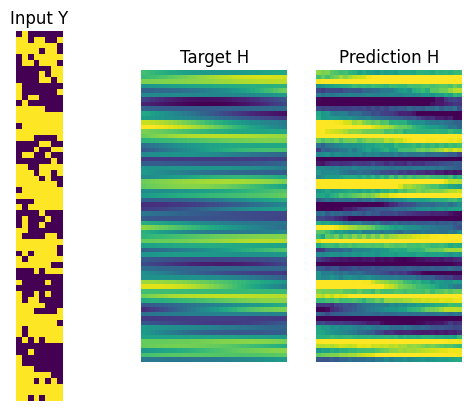

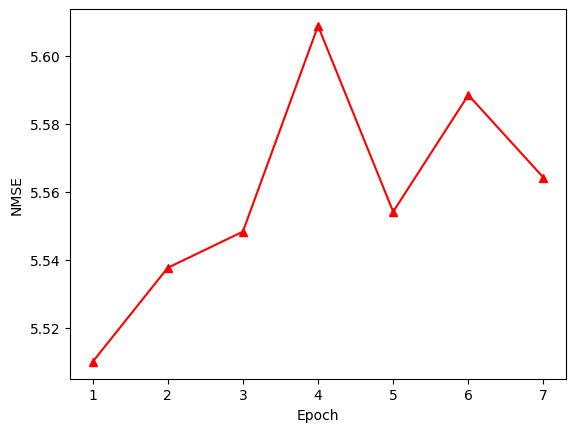

-----
EPOCH: 0
B/E: 0 / 0 , Generator loss: 24.197922 , Discriminator loss: 0.00016422287 , time: 0:00:00.631219
B/E: 103 / 0 , Generator loss: 26.844786 , Discriminator loss: 0.006124209 , time: 0:00:14.954036
B/E: 206 / 0 , Generator loss: 19.551964 , Discriminator loss: 0.034665555 , time: 0:00:28.988364
B/E: 309 / 0 , Generator loss: 21.742218 , Discriminator loss: 0.00031488598 , time: 0:00:42.688968
B/E: 412 / 0 , Generator loss: 18.000015 , Discriminator loss: 0.0022318298 , time: 0:00:56.290377
B/E: 515 / 0 , Generator loss: 21.326431 , Discriminator loss: 0.00053022086 , time: 0:01:10.013164
B/E: 618 / 0 , Generator loss: 19.409813 , Discriminator loss: 0.0013969778 , time: 0:01:23.612641
B/E: 721 / 0 , Generator loss: 26.410831 , Discriminator loss: 1.2638378e-05 , time: 0:01:37.553245
B/E: 824 / 0 , Generator loss: 25.923355 , Discriminator loss: 0.0005333735 , time: 0:01:51.617185
B/E: 927 / 0 , Generator loss: 19.623264 , Discriminator loss: 0.011583813 , time: 0:02:06.998

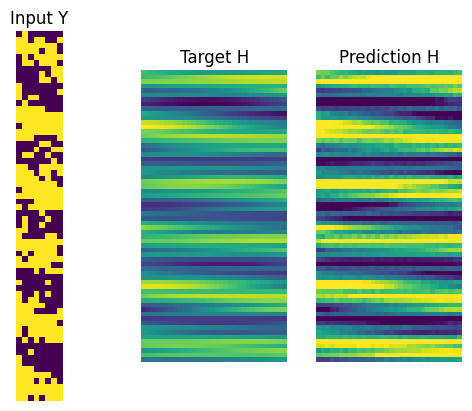

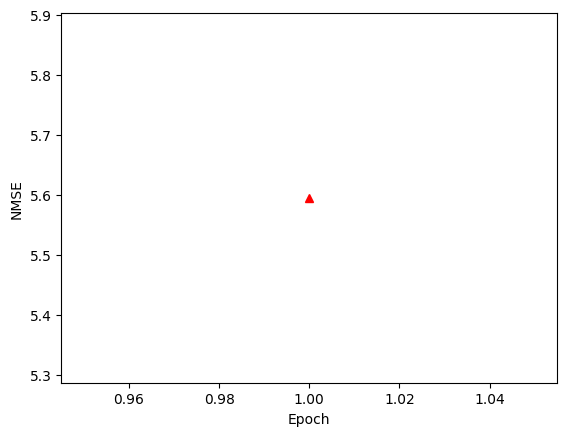

-----
EPOCH: 1
B/E: 0 / 1 , Generator loss: 19.608276 , Discriminator loss: 0.0008464983 , time: 0:03:33.546405
B/E: 103 / 1 , Generator loss: 23.764935 , Discriminator loss: 7.0760975e-06 , time: 0:03:47.511328
B/E: 206 / 1 , Generator loss: 24.952229 , Discriminator loss: 6.46866e-06 , time: 0:04:01.497739
B/E: 309 / 1 , Generator loss: 23.009834 , Discriminator loss: 3.679617e-05 , time: 0:04:15.340573
B/E: 412 / 1 , Generator loss: 21.491135 , Discriminator loss: 0.7969621 , time: 0:04:29.387734
B/E: 515 / 1 , Generator loss: 20.063486 , Discriminator loss: 0.00028297893 , time: 0:04:43.576094
B/E: 618 / 1 , Generator loss: 19.470682 , Discriminator loss: 0.0011743536 , time: 0:04:57.637858
B/E: 721 / 1 , Generator loss: 21.488615 , Discriminator loss: 8.8811285e-05 , time: 0:05:11.745788
B/E: 824 / 1 , Generator loss: 17.761248 , Discriminator loss: 0.0046231556 , time: 0:05:25.600543
B/E: 927 / 1 , Generator loss: 25.00473 , Discriminator loss: 7.2691428e-06 , time: 0:05:39.41503

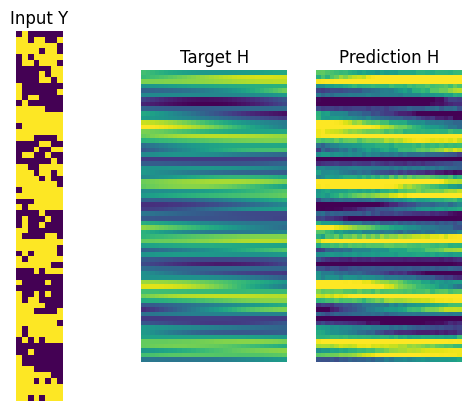

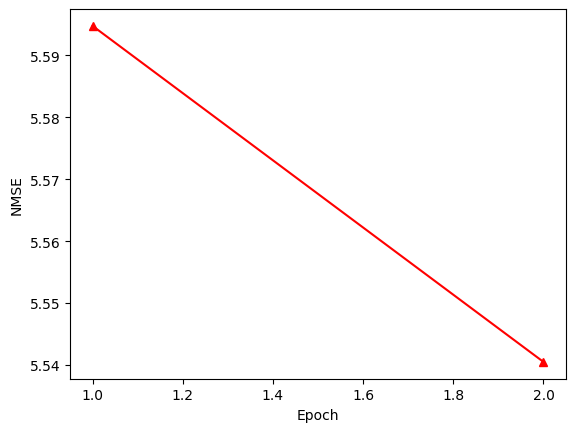

-----
EPOCH: 2
B/E: 0 / 2 , Generator loss: 17.978409 , Discriminator loss: 0.00071750954 , time: 0:07:05.897949
B/E: 103 / 2 , Generator loss: 26.215487 , Discriminator loss: 9.104824e-06 , time: 0:07:19.604388
B/E: 206 / 2 , Generator loss: 27.511587 , Discriminator loss: 1.5561116e-06 , time: 0:07:33.239490
B/E: 309 / 2 , Generator loss: 23.495968 , Discriminator loss: 9.008598e-05 , time: 0:07:46.935129
B/E: 412 / 2 , Generator loss: 15.0397835 , Discriminator loss: 0.010898471 , time: 0:08:00.743524
B/E: 515 / 2 , Generator loss: 17.789358 , Discriminator loss: 0.009305002 , time: 0:08:14.574928
B/E: 618 / 2 , Generator loss: 15.679783 , Discriminator loss: 0.007004689 , time: 0:08:28.250576
B/E: 721 / 2 , Generator loss: 17.808071 , Discriminator loss: 0.0076038074 , time: 0:08:41.923837
B/E: 824 / 2 , Generator loss: 22.48985 , Discriminator loss: 0.0012019267 , time: 0:08:55.629859
B/E: 927 / 2 , Generator loss: 20.86235 , Discriminator loss: 0.16117746 , time: 0:09:09.393984
B

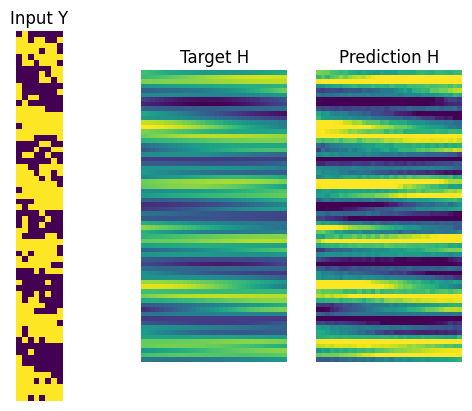

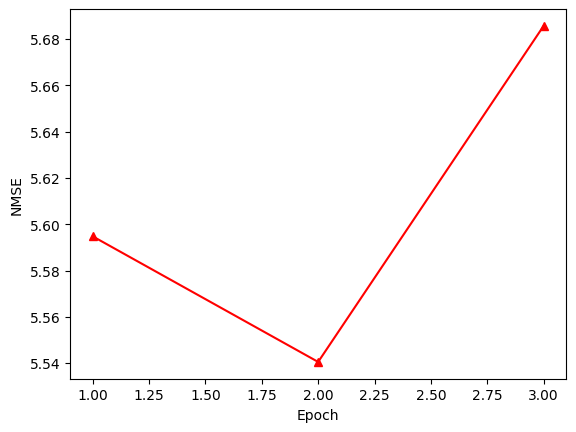

-----
EPOCH: 3
B/E: 0 / 3 , Generator loss: 19.167305 , Discriminator loss: 0.0018205643 , time: 0:10:34.684000
B/E: 103 / 3 , Generator loss: 23.10735 , Discriminator loss: 9.336962e-05 , time: 0:10:48.453284
B/E: 206 / 3 , Generator loss: 27.7861 , Discriminator loss: 2.3805778e-06 , time: 0:11:02.209516
B/E: 309 / 3 , Generator loss: 19.722225 , Discriminator loss: 0.00024629955 , time: 0:11:17.192465
B/E: 412 / 3 , Generator loss: 23.313805 , Discriminator loss: 0.017301949 , time: 0:11:30.897266
B/E: 515 / 3 , Generator loss: 26.970938 , Discriminator loss: 4.796798e-05 , time: 0:11:44.565532
B/E: 618 / 3 , Generator loss: 22.628483 , Discriminator loss: 9.535968e-05 , time: 0:11:58.116905
B/E: 721 / 3 , Generator loss: 22.176056 , Discriminator loss: 0.0035525088 , time: 0:12:11.837874
B/E: 824 / 3 , Generator loss: 16.055683 , Discriminator loss: 0.014308495 , time: 0:12:25.611018
B/E: 927 / 3 , Generator loss: 19.708252 , Discriminator loss: 0.00026495763 , time: 0:12:39.412251

In [ ]:
if __name__ == "__main__":
    snr_list = [-5, 0, 5, 10, 15, 20]
    bs_ant_list = [64, 128]
    avg_nmse = train(epochs=7, snr_list=snr_list, bs_ant_list=bs_ant_list)

    plt.plot(avg_nmse, marker='o')
    plt.xlabel('Model Index')
    plt.ylabel('Average NMSE')
    plt.title('Average NMSE for different SNR and BS Antenna configurations')
    plt.xticks(ticks=range(len(avg_nmse)), labels=[f'SNR={snr}, BS Antenna={bs_ant}' for snr in snr_list for bs_ant in bs_ant_list])
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()


In [ ]:
cd